## PythorchでPix2Pixの実装と2つのネットワークの比較

In [20]:
#utils.py
import numpy as np
from PIL import Image


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('RGB')
    img = img.resize((256, 256), Image.BICUBIC)
    return img


In [21]:
#data.py
from os.path import join


def get_training_set(root_dir, direction):
    train_dir = join(root_dir, "train")

    return DatasetFromFolder(train_dir, direction)


def get_test_set(root_dir, direction):
    test_dir = join(root_dir, "test")

    return DatasetFromFolder(test_dir, direction)


In [22]:
# dataset.py
from os import listdir
from os.path import join
import random

from PIL import Image
import torch
import torch.utils.data as data
import torchvision.transforms as transforms




class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, direction):
        super(DatasetFromFolder, self).__init__()
        self.direction = direction
        self.a_path = join(image_dir, "a")
        self.b_path = join(image_dir, "b")
        self.image_filenames = [x for x in listdir(self.a_path) if is_image_file(x)]

        transform_list = [transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

        self.transform = transforms.Compose(transform_list)

    def __getitem__(self, index):
        a = Image.open(join(self.a_path, self.image_filenames[index])).convert('RGB')
        b = Image.open(join(self.b_path, self.image_filenames[index])).convert('RGB')
        a = a.resize((286, 286), Image.BICUBIC)
        b = b.resize((286, 286), Image.BICUBIC)
        a = transforms.ToTensor()(a)
        b = transforms.ToTensor()(b)
        w_offset = random.randint(0, max(0, 286 - 256 - 1))
        h_offset = random.randint(0, max(0, 286 - 256 - 1))
    
        a = a[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
        b = b[:, h_offset:h_offset + 256, w_offset:w_offset + 256]
    
        a = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(a)
        b = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(b)

        if random.random() < 0.5:
            idx = [i for i in range(a.size(2) - 1, -1, -1)]
            idx = torch.LongTensor(idx)
            a = a.index_select(2, idx)
            b = b.index_select(2, idx)

        if self.direction == "a2b":
            return a, b
        else:
            return b, a

    def __len__(self):
        return len(self.image_filenames)

In [33]:
#networks.py# u-net
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import functools
from torch.optim import lr_scheduler

def get_scheduler(optimizer):
    if lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + epoch_count - niter) / float(niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_decay_iters, gamma=0.1)
    elif lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=niter, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', lr_policy)
    return scheduler


# # update learning rate (called once every epoch)
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)


def get_norm_layer(norm_type):
  if norm_type == 'batch':
    norm_layer = nn.BatchNorm2d
  elif norm_type == 'instance':
    norm_layer = nn.InstanceNorm2d
  else:
    print('normalization layer [%s] is not found' % norm_type)
  return norm_layer


def define_G(input_nc, output_nc, ngf, norm='batch', use_dropout=False, gpu_id='cuda:0'):
  netG = None
  norm_layer = get_norm_layer(norm_type=norm)
  netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9, gpu_id='cuda:0')
  netG.cuda()
  netG.apply(weights_init)
  return netG


def define_D(input_nc, ndf, norm='batch', use_sigmoid=False, gpu_id='cuda:0'):
  netD = None
  norm_layer = get_norm_layer(norm_type=norm)

  netD = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid, gpu_id='cuda:0')

  netD.cuda()
  netD.apply(weights_init)
  return netD


def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)


# Defines the GAN loss which uses either LSGAN or the regular GAN.
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor.cuda())


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, gpu_id='cuda:0'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_id

        model = [nn.Conv2d(input_nc, ngf, kernel_size=7, padding=3),
                 norm_layer(ngf, affine=True),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1),
                      norm_layer(ngf * mult * 2, affine=True),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, 'zero', norm_layer=norm_layer, use_dropout=use_dropout)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1),
                      norm_layer(int(ngf * mult / 2), affine=True),
                      nn.ReLU(True)]

        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout):
        conv_block = []
        p = 0
        assert(padding_type == 'zero')
        p = 1

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim, affine=True),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                       norm_layer(dim, affine=True)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

    
class UnetGenerator(nn.Module):
#Uの底から作っていく
    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):


    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):

        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:#一番浅い層
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:#一番深い層
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up#Leaky Relu + Conv2d + Relu + ConvTrans2d + BatchNorm2d
        else:#中間
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
    
    


# Defines the PatchGAN discriminator.
class NLayerDiscriminator(nn.Module):
  def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_id='cuda:0'):
    super(NLayerDiscriminator, self).__init__()
    self.gpu_ids = gpu_id

    kw = 4
    padw = int(np.ceil((kw-1)/2))
    sequence = [
        nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
        nn.LeakyReLU(0.2, True)
    ]

    nf_mult = 1
    nf_mult_prev = 1
    for n in range(1, n_layers):
        nf_mult_prev = nf_mult
        nf_mult = min(2**n, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2,
                      padding=padw), norm_layer(ndf * nf_mult,
                                                affine=True), nn.LeakyReLU(0.2, True)
        ]

    nf_mult_prev = nf_mult
    nf_mult = min(2**n_layers, 8)
    sequence += [
        nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1,
                  padding=padw), norm_layer(ndf * nf_mult,
                                            affine=True), nn.LeakyReLU(0.2, True)
    ]

    sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

    if use_sigmoid:
        sequence += [nn.Sigmoid()]

    self.model = nn.Sequential(*sequence)

  def forward(self, input):
      return self.model(input)

In [34]:
#train.py
from __future__ import print_function
import argparse
import os
from math import log10

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import random
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size =1
test_batch_size=1
input_nc=3
output_nc=3
ngf=64
ndf=64
epoch_count=1
niter=100
niter_decay=100
lr=0.0002
lr_policy='lambda'
lr_decay_iters=50
beta1=0.5
threads=0
lamb=10

print('===> Loading datasets')
# root_path = "resize/"
train_set = get_training_set('dataset', 'b2a')
test_set = get_test_set('dataset', 'b2a')
training_data_loader = DataLoader(dataset=train_set, num_workers=threads, batch_size=batch_size, shuffle=True)
testing_data_loader = DataLoader(dataset=test_set, num_workers=threads, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('===> Building models')

#normal conv deconv#################################
# net_g = define_G(input_nc, output_nc, ngf, 'batch', False, 'normal', 0.02, gpu_id=device)
# net_d = define_D(input_nc + output_nc, ndf, 'basic', gpu_id=device)
#####################################################


#u-net####################################################
net_g = UnetGenerator(input_nc, output_nc, 7, use_dropout=True)
net_g.to(device)
net_d = define_D(input_nc + output_nc, ndf, 'batch', False,  gpu_id=device)
#########################################################



criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

# setup optimizer
optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
net_g_scheduler = get_scheduler(optimizer_g)
net_d_scheduler = get_scheduler(optimizer_d)

for epoch in range(epoch_count,  51):
    # train
    for iteration, batch in enumerate(training_data_loader, 1):
        # forward
        real_a, real_b = batch[0].to(device), batch[1].to(device)
        fake_b = net_g(real_a)

        ######################
        # (1) Update D network
        ######################

        optimizer_d.zero_grad()
        
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = net_d.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5

        loss_d.backward()
       
        optimizer_d.step()

        ######################
        # (2) Update G network
        ######################

        optimizer_g.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = net_d.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * lamb
        
        loss_g = loss_g_gan + loss_g_l1
        
        loss_g.backward()

        optimizer_g.step()

        print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(training_data_loader), loss_d.item(), loss_g.item()))

    update_learning_rate(net_g_scheduler, optimizer_g)
    update_learning_rate(net_d_scheduler, optimizer_d)

    # test
    avg_psnr = 0
    for batch in testing_data_loader:
        input, target = batch[0].to(device), batch[1].to(device)

        prediction = net_g(input)
        mse = criterionMSE(prediction, target)
        psnr = 10 * log10(1 / mse.item())
        avg_psnr += psnr
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))

    #checkpoint
    if epoch % 50 == 0:
        net_g_model_out_path = "checkpoint/dataset2/unetG_model_epoch_{}.pth".format(epoch)
        net_d_model_out_path = "checkpoint/dataset2/unetD_model_epoch_{}.pth".format(epoch)
        torch.save(net_g, net_g_model_out_path)
        torch.save(net_d, net_d_model_out_path)
        print("Checkpoint saved to {}".format("checkpoint/dataset2"))
        

===> Loading datasets
===> Building models
===> Epoch[1](1/254): Loss_D: 1.4822 Loss_G: 9.6173
===> Epoch[1](2/254): Loss_D: 3.9942 Loss_G: 7.6627
===> Epoch[1](3/254): Loss_D: 3.9342 Loss_G: 8.0935
===> Epoch[1](4/254): Loss_D: 1.4960 Loss_G: 7.4785
===> Epoch[1](5/254): Loss_D: 1.4398 Loss_G: 7.9272
===> Epoch[1](6/254): Loss_D: 1.4007 Loss_G: 7.9580
===> Epoch[1](7/254): Loss_D: 0.9458 Loss_G: 7.3211
===> Epoch[1](8/254): Loss_D: 1.1166 Loss_G: 7.8509
===> Epoch[1](9/254): Loss_D: 1.0174 Loss_G: 9.9086
===> Epoch[1](10/254): Loss_D: 1.0682 Loss_G: 7.0043
===> Epoch[1](11/254): Loss_D: 0.8429 Loss_G: 6.8824
===> Epoch[1](12/254): Loss_D: 0.8912 Loss_G: 6.5541
===> Epoch[1](13/254): Loss_D: 1.0724 Loss_G: 7.6384
===> Epoch[1](14/254): Loss_D: 1.5008 Loss_G: 7.3746
===> Epoch[1](15/254): Loss_D: 1.2465 Loss_G: 7.1891
===> Epoch[1](16/254): Loss_D: 1.1794 Loss_G: 5.9985
===> Epoch[1](17/254): Loss_D: 1.0984 Loss_G: 6.4472
===> Epoch[1](18/254): Loss_D: 1.2801 Loss_G: 8.0389
===> Epoch[1

===> Epoch[1](155/254): Loss_D: 0.1568 Loss_G: 5.5899
===> Epoch[1](156/254): Loss_D: 0.3725 Loss_G: 5.0981
===> Epoch[1](157/254): Loss_D: 0.4936 Loss_G: 5.8336
===> Epoch[1](158/254): Loss_D: 0.3369 Loss_G: 6.8376
===> Epoch[1](159/254): Loss_D: 0.7800 Loss_G: 6.0146
===> Epoch[1](160/254): Loss_D: 0.4096 Loss_G: 5.6083
===> Epoch[1](161/254): Loss_D: 0.4829 Loss_G: 7.1204
===> Epoch[1](162/254): Loss_D: 0.7388 Loss_G: 5.5652
===> Epoch[1](163/254): Loss_D: 0.5648 Loss_G: 4.3999
===> Epoch[1](164/254): Loss_D: 0.4158 Loss_G: 4.5322
===> Epoch[1](165/254): Loss_D: 0.9237 Loss_G: 5.7317
===> Epoch[1](166/254): Loss_D: 0.8802 Loss_G: 8.7483
===> Epoch[1](167/254): Loss_D: 0.9139 Loss_G: 6.6500
===> Epoch[1](168/254): Loss_D: 0.6216 Loss_G: 5.0746
===> Epoch[1](169/254): Loss_D: 2.5415 Loss_G: 14.6421
===> Epoch[1](170/254): Loss_D: 4.3495 Loss_G: 6.6378
===> Epoch[1](171/254): Loss_D: 1.7320 Loss_G: 8.0031
===> Epoch[1](172/254): Loss_D: 2.0161 Loss_G: 6.5362
===> Epoch[1](173/254): Los

===> Epoch[2](54/254): Loss_D: 0.1861 Loss_G: 5.9240
===> Epoch[2](55/254): Loss_D: 0.1382 Loss_G: 8.3984
===> Epoch[2](56/254): Loss_D: 0.1592 Loss_G: 3.8232
===> Epoch[2](57/254): Loss_D: 0.2037 Loss_G: 4.7061
===> Epoch[2](58/254): Loss_D: 0.1549 Loss_G: 4.1398
===> Epoch[2](59/254): Loss_D: 0.1460 Loss_G: 5.4427
===> Epoch[2](60/254): Loss_D: 0.3017 Loss_G: 3.8151
===> Epoch[2](61/254): Loss_D: 0.2434 Loss_G: 3.9764
===> Epoch[2](62/254): Loss_D: 0.2765 Loss_G: 4.1329
===> Epoch[2](63/254): Loss_D: 0.1856 Loss_G: 5.3795
===> Epoch[2](64/254): Loss_D: 0.1077 Loss_G: 5.4804
===> Epoch[2](65/254): Loss_D: 0.1628 Loss_G: 6.4741
===> Epoch[2](66/254): Loss_D: 0.1439 Loss_G: 7.3555
===> Epoch[2](67/254): Loss_D: 0.0597 Loss_G: 6.9427
===> Epoch[2](68/254): Loss_D: 0.0772 Loss_G: 5.3366
===> Epoch[2](69/254): Loss_D: 0.1704 Loss_G: 5.6585
===> Epoch[2](70/254): Loss_D: 0.1747 Loss_G: 7.3355
===> Epoch[2](71/254): Loss_D: 0.1671 Loss_G: 6.5046
===> Epoch[2](72/254): Loss_D: 0.0973 Loss_G: 

===> Epoch[2](208/254): Loss_D: 0.3899 Loss_G: 4.7722
===> Epoch[2](209/254): Loss_D: 0.2612 Loss_G: 7.8028
===> Epoch[2](210/254): Loss_D: 0.5319 Loss_G: 5.7844
===> Epoch[2](211/254): Loss_D: 0.4001 Loss_G: 5.1410
===> Epoch[2](212/254): Loss_D: 0.2653 Loss_G: 4.2989
===> Epoch[2](213/254): Loss_D: 0.3223 Loss_G: 4.9590
===> Epoch[2](214/254): Loss_D: 0.2718 Loss_G: 4.1688
===> Epoch[2](215/254): Loss_D: 0.1887 Loss_G: 4.9490
===> Epoch[2](216/254): Loss_D: 0.2830 Loss_G: 4.2010
===> Epoch[2](217/254): Loss_D: 0.2015 Loss_G: 5.0322
===> Epoch[2](218/254): Loss_D: 0.1953 Loss_G: 4.5055
===> Epoch[2](219/254): Loss_D: 0.1085 Loss_G: 6.1981
===> Epoch[2](220/254): Loss_D: 0.1763 Loss_G: 6.2934
===> Epoch[2](221/254): Loss_D: 0.2392 Loss_G: 4.7532
===> Epoch[2](222/254): Loss_D: 0.0589 Loss_G: 6.2263
===> Epoch[2](223/254): Loss_D: 0.0657 Loss_G: 6.7914
===> Epoch[2](224/254): Loss_D: 0.1093 Loss_G: 4.3439
===> Epoch[2](225/254): Loss_D: 0.1078 Loss_G: 5.1129
===> Epoch[2](226/254): Loss

===> Epoch[3](108/254): Loss_D: 0.1854 Loss_G: 6.2892
===> Epoch[3](109/254): Loss_D: 0.2458 Loss_G: 5.4260
===> Epoch[3](110/254): Loss_D: 0.2553 Loss_G: 3.7104
===> Epoch[3](111/254): Loss_D: 0.3610 Loss_G: 9.7985
===> Epoch[3](112/254): Loss_D: 0.2229 Loss_G: 5.9201
===> Epoch[3](113/254): Loss_D: 0.1995 Loss_G: 6.7716
===> Epoch[3](114/254): Loss_D: 0.2707 Loss_G: 5.1828
===> Epoch[3](115/254): Loss_D: 0.2945 Loss_G: 6.3167
===> Epoch[3](116/254): Loss_D: 0.0841 Loss_G: 6.4435
===> Epoch[3](117/254): Loss_D: 0.2042 Loss_G: 4.8064
===> Epoch[3](118/254): Loss_D: 0.1162 Loss_G: 5.6300
===> Epoch[3](119/254): Loss_D: 0.2924 Loss_G: 4.8369
===> Epoch[3](120/254): Loss_D: 0.5326 Loss_G: 4.5283
===> Epoch[3](121/254): Loss_D: 0.1998 Loss_G: 6.6915
===> Epoch[3](122/254): Loss_D: 0.2420 Loss_G: 6.9351
===> Epoch[3](123/254): Loss_D: 0.4637 Loss_G: 6.2537
===> Epoch[3](124/254): Loss_D: 0.2477 Loss_G: 5.7724
===> Epoch[3](125/254): Loss_D: 0.3476 Loss_G: 4.4742
===> Epoch[3](126/254): Loss

===> Epoch[4](6/254): Loss_D: 0.1998 Loss_G: 5.0927
===> Epoch[4](7/254): Loss_D: 0.1025 Loss_G: 5.8562
===> Epoch[4](8/254): Loss_D: 0.2227 Loss_G: 4.6844
===> Epoch[4](9/254): Loss_D: 0.1054 Loss_G: 6.2549
===> Epoch[4](10/254): Loss_D: 0.0577 Loss_G: 7.0223
===> Epoch[4](11/254): Loss_D: 0.2391 Loss_G: 7.3980
===> Epoch[4](12/254): Loss_D: 0.2080 Loss_G: 5.2729
===> Epoch[4](13/254): Loss_D: 0.3478 Loss_G: 3.3056
===> Epoch[4](14/254): Loss_D: 0.3680 Loss_G: 4.5055
===> Epoch[4](15/254): Loss_D: 0.2727 Loss_G: 6.2267
===> Epoch[4](16/254): Loss_D: 0.1037 Loss_G: 8.3377
===> Epoch[4](17/254): Loss_D: 0.2512 Loss_G: 5.3217
===> Epoch[4](18/254): Loss_D: 0.1671 Loss_G: 4.4052
===> Epoch[4](19/254): Loss_D: 0.1434 Loss_G: 6.6544
===> Epoch[4](20/254): Loss_D: 0.3170 Loss_G: 4.7379
===> Epoch[4](21/254): Loss_D: 0.2646 Loss_G: 5.7094
===> Epoch[4](22/254): Loss_D: 0.1567 Loss_G: 6.4894
===> Epoch[4](23/254): Loss_D: 0.1604 Loss_G: 5.4397
===> Epoch[4](24/254): Loss_D: 0.2934 Loss_G: 4.37

===> Epoch[4](160/254): Loss_D: 0.1410 Loss_G: 5.5338
===> Epoch[4](161/254): Loss_D: 0.2319 Loss_G: 6.3782
===> Epoch[4](162/254): Loss_D: 0.5008 Loss_G: 4.1345
===> Epoch[4](163/254): Loss_D: 0.1395 Loss_G: 4.5429
===> Epoch[4](164/254): Loss_D: 0.1632 Loss_G: 4.8977
===> Epoch[4](165/254): Loss_D: 0.1153 Loss_G: 5.8859
===> Epoch[4](166/254): Loss_D: 0.0952 Loss_G: 5.7922
===> Epoch[4](167/254): Loss_D: 0.2974 Loss_G: 3.7490
===> Epoch[4](168/254): Loss_D: 0.2174 Loss_G: 3.9044
===> Epoch[4](169/254): Loss_D: 0.1604 Loss_G: 4.3538
===> Epoch[4](170/254): Loss_D: 0.0997 Loss_G: 5.9521
===> Epoch[4](171/254): Loss_D: 0.0408 Loss_G: 6.9647
===> Epoch[4](172/254): Loss_D: 0.2697 Loss_G: 4.2296
===> Epoch[4](173/254): Loss_D: 0.1234 Loss_G: 5.3805
===> Epoch[4](174/254): Loss_D: 0.0699 Loss_G: 5.7627
===> Epoch[4](175/254): Loss_D: 0.1727 Loss_G: 5.5854
===> Epoch[4](176/254): Loss_D: 0.0768 Loss_G: 6.2325
===> Epoch[4](177/254): Loss_D: 0.4088 Loss_G: 3.9890
===> Epoch[4](178/254): Loss

===> Epoch[5](58/254): Loss_D: 0.2941 Loss_G: 4.5957
===> Epoch[5](59/254): Loss_D: 0.1773 Loss_G: 4.2451
===> Epoch[5](60/254): Loss_D: 0.1049 Loss_G: 6.4383
===> Epoch[5](61/254): Loss_D: 0.4670 Loss_G: 5.2089
===> Epoch[5](62/254): Loss_D: 0.2091 Loss_G: 4.8116
===> Epoch[5](63/254): Loss_D: 0.1641 Loss_G: 4.6266
===> Epoch[5](64/254): Loss_D: 0.2976 Loss_G: 4.7715
===> Epoch[5](65/254): Loss_D: 0.2516 Loss_G: 5.1750
===> Epoch[5](66/254): Loss_D: 0.5781 Loss_G: 5.2783
===> Epoch[5](67/254): Loss_D: 0.3126 Loss_G: 4.3500
===> Epoch[5](68/254): Loss_D: 0.2397 Loss_G: 6.5885
===> Epoch[5](69/254): Loss_D: 0.1446 Loss_G: 6.4947
===> Epoch[5](70/254): Loss_D: 0.1774 Loss_G: 4.5478
===> Epoch[5](71/254): Loss_D: 0.0728 Loss_G: 5.7385
===> Epoch[5](72/254): Loss_D: 0.0779 Loss_G: 4.6726
===> Epoch[5](73/254): Loss_D: 0.0622 Loss_G: 8.2487
===> Epoch[5](74/254): Loss_D: 0.2734 Loss_G: 4.3426
===> Epoch[5](75/254): Loss_D: 0.0799 Loss_G: 7.1398
===> Epoch[5](76/254): Loss_D: 0.1884 Loss_G: 

===> Epoch[5](211/254): Loss_D: 0.1917 Loss_G: 6.1197
===> Epoch[5](212/254): Loss_D: 0.1457 Loss_G: 5.6683
===> Epoch[5](213/254): Loss_D: 0.1362 Loss_G: 5.4274
===> Epoch[5](214/254): Loss_D: 0.2502 Loss_G: 5.8508
===> Epoch[5](215/254): Loss_D: 0.1124 Loss_G: 5.1537
===> Epoch[5](216/254): Loss_D: 0.1733 Loss_G: 5.2328
===> Epoch[5](217/254): Loss_D: 0.1302 Loss_G: 5.7171
===> Epoch[5](218/254): Loss_D: 0.0695 Loss_G: 5.1129
===> Epoch[5](219/254): Loss_D: 0.0623 Loss_G: 7.1586
===> Epoch[5](220/254): Loss_D: 0.1997 Loss_G: 4.8639
===> Epoch[5](221/254): Loss_D: 0.0786 Loss_G: 7.9044
===> Epoch[5](222/254): Loss_D: 0.1339 Loss_G: 6.2492
===> Epoch[5](223/254): Loss_D: 0.0512 Loss_G: 5.3380
===> Epoch[5](224/254): Loss_D: 0.1677 Loss_G: 6.1238
===> Epoch[5](225/254): Loss_D: 0.0831 Loss_G: 7.6166
===> Epoch[5](226/254): Loss_D: 0.2700 Loss_G: 7.1163
===> Epoch[5](227/254): Loss_D: 0.0992 Loss_G: 4.8556
===> Epoch[5](228/254): Loss_D: 0.0629 Loss_G: 5.7507
===> Epoch[5](229/254): Loss

===> Epoch[6](110/254): Loss_D: 0.2382 Loss_G: 6.9451
===> Epoch[6](111/254): Loss_D: 0.3698 Loss_G: 4.4276
===> Epoch[6](112/254): Loss_D: 0.0914 Loss_G: 6.3027
===> Epoch[6](113/254): Loss_D: 0.0729 Loss_G: 6.4022
===> Epoch[6](114/254): Loss_D: 0.3336 Loss_G: 4.3331
===> Epoch[6](115/254): Loss_D: 0.3107 Loss_G: 4.7082
===> Epoch[6](116/254): Loss_D: 0.2321 Loss_G: 4.4540
===> Epoch[6](117/254): Loss_D: 0.2186 Loss_G: 4.7642
===> Epoch[6](118/254): Loss_D: 0.1140 Loss_G: 7.8328
===> Epoch[6](119/254): Loss_D: 0.3140 Loss_G: 3.7808
===> Epoch[6](120/254): Loss_D: 0.1182 Loss_G: 5.3827
===> Epoch[6](121/254): Loss_D: 0.1826 Loss_G: 5.9611
===> Epoch[6](122/254): Loss_D: 0.1341 Loss_G: 6.1389
===> Epoch[6](123/254): Loss_D: 0.4509 Loss_G: 5.8510
===> Epoch[6](124/254): Loss_D: 0.1247 Loss_G: 5.9563
===> Epoch[6](125/254): Loss_D: 0.1774 Loss_G: 6.0559
===> Epoch[6](126/254): Loss_D: 0.1983 Loss_G: 5.5358
===> Epoch[6](127/254): Loss_D: 0.1167 Loss_G: 7.0660
===> Epoch[6](128/254): Loss

===> Epoch[7](8/254): Loss_D: 0.2789 Loss_G: 6.6946
===> Epoch[7](9/254): Loss_D: 0.0464 Loss_G: 9.3812
===> Epoch[7](10/254): Loss_D: 0.3527 Loss_G: 5.0539
===> Epoch[7](11/254): Loss_D: 0.1745 Loss_G: 4.8803
===> Epoch[7](12/254): Loss_D: 0.1733 Loss_G: 4.6736
===> Epoch[7](13/254): Loss_D: 0.3205 Loss_G: 4.2318
===> Epoch[7](14/254): Loss_D: 0.3856 Loss_G: 3.5908
===> Epoch[7](15/254): Loss_D: 0.1840 Loss_G: 5.0206
===> Epoch[7](16/254): Loss_D: 0.0539 Loss_G: 7.6652
===> Epoch[7](17/254): Loss_D: 0.2209 Loss_G: 4.8431
===> Epoch[7](18/254): Loss_D: 0.1033 Loss_G: 5.0990
===> Epoch[7](19/254): Loss_D: 0.2562 Loss_G: 4.3870
===> Epoch[7](20/254): Loss_D: 0.1561 Loss_G: 7.4213
===> Epoch[7](21/254): Loss_D: 0.0356 Loss_G: 8.3057
===> Epoch[7](22/254): Loss_D: 0.2595 Loss_G: 5.2692
===> Epoch[7](23/254): Loss_D: 0.2431 Loss_G: 4.6767
===> Epoch[7](24/254): Loss_D: 0.2719 Loss_G: 4.1229
===> Epoch[7](25/254): Loss_D: 0.1903 Loss_G: 5.6258
===> Epoch[7](26/254): Loss_D: 0.0801 Loss_G: 7.

===> Epoch[7](163/254): Loss_D: 0.1482 Loss_G: 4.0658
===> Epoch[7](164/254): Loss_D: 0.2187 Loss_G: 5.1375
===> Epoch[7](165/254): Loss_D: 0.3744 Loss_G: 4.4222
===> Epoch[7](166/254): Loss_D: 0.1677 Loss_G: 6.7132
===> Epoch[7](167/254): Loss_D: 0.1623 Loss_G: 5.2628
===> Epoch[7](168/254): Loss_D: 0.0765 Loss_G: 4.9629
===> Epoch[7](169/254): Loss_D: 0.1416 Loss_G: 4.0315
===> Epoch[7](170/254): Loss_D: 0.2640 Loss_G: 3.0477
===> Epoch[7](171/254): Loss_D: 0.1948 Loss_G: 4.9410
===> Epoch[7](172/254): Loss_D: 0.0805 Loss_G: 5.5965
===> Epoch[7](173/254): Loss_D: 0.2463 Loss_G: 4.2236
===> Epoch[7](174/254): Loss_D: 0.0799 Loss_G: 6.2253
===> Epoch[7](175/254): Loss_D: 0.1923 Loss_G: 5.6718
===> Epoch[7](176/254): Loss_D: 0.2195 Loss_G: 5.5332
===> Epoch[7](177/254): Loss_D: 0.1550 Loss_G: 5.2221
===> Epoch[7](178/254): Loss_D: 0.0494 Loss_G: 7.4187
===> Epoch[7](179/254): Loss_D: 0.0403 Loss_G: 5.8241
===> Epoch[7](180/254): Loss_D: 0.1256 Loss_G: 5.4538
===> Epoch[7](181/254): Loss

===> Epoch[8](62/254): Loss_D: 0.3372 Loss_G: 3.9215
===> Epoch[8](63/254): Loss_D: 0.2024 Loss_G: 4.9144
===> Epoch[8](64/254): Loss_D: 0.0870 Loss_G: 7.3242
===> Epoch[8](65/254): Loss_D: 0.5705 Loss_G: 4.9837
===> Epoch[8](66/254): Loss_D: 0.1447 Loss_G: 3.8764
===> Epoch[8](67/254): Loss_D: 0.2778 Loss_G: 4.4055
===> Epoch[8](68/254): Loss_D: 0.4060 Loss_G: 4.0714
===> Epoch[8](69/254): Loss_D: 0.1161 Loss_G: 6.8993
===> Epoch[8](70/254): Loss_D: 0.1432 Loss_G: 4.8554
===> Epoch[8](71/254): Loss_D: 0.2104 Loss_G: 4.4685
===> Epoch[8](72/254): Loss_D: 0.1432 Loss_G: 4.1798
===> Epoch[8](73/254): Loss_D: 0.1304 Loss_G: 5.2334
===> Epoch[8](74/254): Loss_D: 0.4726 Loss_G: 4.1173
===> Epoch[8](75/254): Loss_D: 0.1201 Loss_G: 5.2244
===> Epoch[8](76/254): Loss_D: 0.3767 Loss_G: 3.5760
===> Epoch[8](77/254): Loss_D: 0.2742 Loss_G: 3.4678
===> Epoch[8](78/254): Loss_D: 0.2217 Loss_G: 3.9325
===> Epoch[8](79/254): Loss_D: 0.2294 Loss_G: 3.6698
===> Epoch[8](80/254): Loss_D: 0.1691 Loss_G: 

===> Epoch[8](215/254): Loss_D: 0.2807 Loss_G: 8.0887
===> Epoch[8](216/254): Loss_D: 0.3803 Loss_G: 4.7911
===> Epoch[8](217/254): Loss_D: 0.5784 Loss_G: 4.2702
===> Epoch[8](218/254): Loss_D: 0.1914 Loss_G: 5.9086
===> Epoch[8](219/254): Loss_D: 0.2694 Loss_G: 5.1262
===> Epoch[8](220/254): Loss_D: 0.1756 Loss_G: 6.5633
===> Epoch[8](221/254): Loss_D: 0.1877 Loss_G: 5.2878
===> Epoch[8](222/254): Loss_D: 0.1283 Loss_G: 5.2729
===> Epoch[8](223/254): Loss_D: 0.2015 Loss_G: 3.6403
===> Epoch[8](224/254): Loss_D: 0.1189 Loss_G: 7.9694
===> Epoch[8](225/254): Loss_D: 0.0631 Loss_G: 6.6653
===> Epoch[8](226/254): Loss_D: 0.1160 Loss_G: 5.9055
===> Epoch[8](227/254): Loss_D: 0.0679 Loss_G: 4.2678
===> Epoch[8](228/254): Loss_D: 0.0856 Loss_G: 5.8746
===> Epoch[8](229/254): Loss_D: 0.0772 Loss_G: 7.3518
===> Epoch[8](230/254): Loss_D: 0.1655 Loss_G: 5.7520
===> Epoch[8](231/254): Loss_D: 0.3615 Loss_G: 5.0902
===> Epoch[8](232/254): Loss_D: 0.1400 Loss_G: 6.0013
===> Epoch[8](233/254): Loss

===> Epoch[9](114/254): Loss_D: 0.2008 Loss_G: 4.5953
===> Epoch[9](115/254): Loss_D: 0.1563 Loss_G: 6.6396
===> Epoch[9](116/254): Loss_D: 0.1040 Loss_G: 4.9122
===> Epoch[9](117/254): Loss_D: 0.0601 Loss_G: 5.5315
===> Epoch[9](118/254): Loss_D: 0.1167 Loss_G: 5.9284
===> Epoch[9](119/254): Loss_D: 0.1286 Loss_G: 4.1425
===> Epoch[9](120/254): Loss_D: 0.3255 Loss_G: 4.5041
===> Epoch[9](121/254): Loss_D: 0.1235 Loss_G: 5.9484
===> Epoch[9](122/254): Loss_D: 0.0646 Loss_G: 6.0431
===> Epoch[9](123/254): Loss_D: 0.0854 Loss_G: 6.1000
===> Epoch[9](124/254): Loss_D: 0.0449 Loss_G: 6.1348
===> Epoch[9](125/254): Loss_D: 0.2028 Loss_G: 4.0330
===> Epoch[9](126/254): Loss_D: 0.1294 Loss_G: 5.4855
===> Epoch[9](127/254): Loss_D: 0.0653 Loss_G: 5.4586
===> Epoch[9](128/254): Loss_D: 0.0533 Loss_G: 7.3495
===> Epoch[9](129/254): Loss_D: 0.2112 Loss_G: 6.1589
===> Epoch[9](130/254): Loss_D: 0.0508 Loss_G: 5.1570
===> Epoch[9](131/254): Loss_D: 0.1585 Loss_G: 4.1661
===> Epoch[9](132/254): Loss

===> Epoch[10](12/254): Loss_D: 0.3375 Loss_G: 4.1337
===> Epoch[10](13/254): Loss_D: 0.2089 Loss_G: 3.8438
===> Epoch[10](14/254): Loss_D: 0.2164 Loss_G: 6.0464
===> Epoch[10](15/254): Loss_D: 0.2088 Loss_G: 4.9210
===> Epoch[10](16/254): Loss_D: 0.1127 Loss_G: 5.6729
===> Epoch[10](17/254): Loss_D: 0.0540 Loss_G: 6.0668
===> Epoch[10](18/254): Loss_D: 0.1651 Loss_G: 5.0441
===> Epoch[10](19/254): Loss_D: 0.0976 Loss_G: 5.5134
===> Epoch[10](20/254): Loss_D: 0.0630 Loss_G: 6.5771
===> Epoch[10](21/254): Loss_D: 0.0829 Loss_G: 5.4846
===> Epoch[10](22/254): Loss_D: 0.1816 Loss_G: 3.8804
===> Epoch[10](23/254): Loss_D: 0.1382 Loss_G: 5.7017
===> Epoch[10](24/254): Loss_D: 0.1623 Loss_G: 4.9894
===> Epoch[10](25/254): Loss_D: 0.1630 Loss_G: 5.2453
===> Epoch[10](26/254): Loss_D: 0.2508 Loss_G: 3.9028
===> Epoch[10](27/254): Loss_D: 0.2262 Loss_G: 5.4790
===> Epoch[10](28/254): Loss_D: 0.2914 Loss_G: 4.4012
===> Epoch[10](29/254): Loss_D: 0.3522 Loss_G: 3.0779
===> Epoch[10](30/254): Loss

===> Epoch[10](163/254): Loss_D: 0.1384 Loss_G: 4.6391
===> Epoch[10](164/254): Loss_D: 0.1353 Loss_G: 5.7005
===> Epoch[10](165/254): Loss_D: 0.1463 Loss_G: 5.8236
===> Epoch[10](166/254): Loss_D: 0.0517 Loss_G: 6.3050
===> Epoch[10](167/254): Loss_D: 0.0792 Loss_G: 5.2483
===> Epoch[10](168/254): Loss_D: 0.1189 Loss_G: 4.8408
===> Epoch[10](169/254): Loss_D: 0.0537 Loss_G: 4.5901
===> Epoch[10](170/254): Loss_D: 0.0692 Loss_G: 5.6468
===> Epoch[10](171/254): Loss_D: 0.1474 Loss_G: 4.6384
===> Epoch[10](172/254): Loss_D: 0.1264 Loss_G: 5.2965
===> Epoch[10](173/254): Loss_D: 0.2885 Loss_G: 3.7683
===> Epoch[10](174/254): Loss_D: 0.1446 Loss_G: 6.8822
===> Epoch[10](175/254): Loss_D: 0.4111 Loss_G: 4.8914
===> Epoch[10](176/254): Loss_D: 0.2294 Loss_G: 4.4116
===> Epoch[10](177/254): Loss_D: 0.4098 Loss_G: 3.8742
===> Epoch[10](178/254): Loss_D: 0.2546 Loss_G: 3.7965
===> Epoch[10](179/254): Loss_D: 0.1515 Loss_G: 3.9942
===> Epoch[10](180/254): Loss_D: 0.1163 Loss_G: 4.8478
===> Epoch

===> Epoch[11](58/254): Loss_D: 0.1470 Loss_G: 4.9257
===> Epoch[11](59/254): Loss_D: 0.1019 Loss_G: 6.1431
===> Epoch[11](60/254): Loss_D: 0.5359 Loss_G: 4.0978
===> Epoch[11](61/254): Loss_D: 0.1350 Loss_G: 5.3723
===> Epoch[11](62/254): Loss_D: 0.1921 Loss_G: 4.9022
===> Epoch[11](63/254): Loss_D: 0.1587 Loss_G: 6.2633
===> Epoch[11](64/254): Loss_D: 0.0571 Loss_G: 6.6392
===> Epoch[11](65/254): Loss_D: 0.2431 Loss_G: 4.1175
===> Epoch[11](66/254): Loss_D: 0.1530 Loss_G: 6.2546
===> Epoch[11](67/254): Loss_D: 0.0733 Loss_G: 6.4989
===> Epoch[11](68/254): Loss_D: 0.1058 Loss_G: 5.3751
===> Epoch[11](69/254): Loss_D: 0.0569 Loss_G: 6.3763
===> Epoch[11](70/254): Loss_D: 0.0338 Loss_G: 5.7772
===> Epoch[11](71/254): Loss_D: 0.0701 Loss_G: 7.5279
===> Epoch[11](72/254): Loss_D: 0.0477 Loss_G: 6.3590
===> Epoch[11](73/254): Loss_D: 0.0529 Loss_G: 6.9005
===> Epoch[11](74/254): Loss_D: 0.1587 Loss_G: 4.2886
===> Epoch[11](75/254): Loss_D: 0.3107 Loss_G: 3.4642
===> Epoch[11](76/254): Loss

===> Epoch[11](208/254): Loss_D: 0.1213 Loss_G: 3.8870
===> Epoch[11](209/254): Loss_D: 0.1192 Loss_G: 6.6563
===> Epoch[11](210/254): Loss_D: 0.0752 Loss_G: 5.5942
===> Epoch[11](211/254): Loss_D: 0.0867 Loss_G: 6.0028
===> Epoch[11](212/254): Loss_D: 0.1046 Loss_G: 5.7230
===> Epoch[11](213/254): Loss_D: 0.0558 Loss_G: 5.7462
===> Epoch[11](214/254): Loss_D: 0.1156 Loss_G: 5.4186
===> Epoch[11](215/254): Loss_D: 0.0470 Loss_G: 6.7400
===> Epoch[11](216/254): Loss_D: 0.0262 Loss_G: 6.2602
===> Epoch[11](217/254): Loss_D: 0.0835 Loss_G: 5.4865
===> Epoch[11](218/254): Loss_D: 0.0447 Loss_G: 7.3146
===> Epoch[11](219/254): Loss_D: 0.0390 Loss_G: 5.8097
===> Epoch[11](220/254): Loss_D: 0.0258 Loss_G: 8.7737
===> Epoch[11](221/254): Loss_D: 0.1880 Loss_G: 4.8045
===> Epoch[11](222/254): Loss_D: 0.1709 Loss_G: 5.1405
===> Epoch[11](223/254): Loss_D: 0.0699 Loss_G: 6.3073
===> Epoch[11](224/254): Loss_D: 0.3479 Loss_G: 3.6507
===> Epoch[11](225/254): Loss_D: 0.1325 Loss_G: 5.8042
===> Epoch

===> Epoch[12](104/254): Loss_D: 0.0618 Loss_G: 7.8024
===> Epoch[12](105/254): Loss_D: 0.3192 Loss_G: 5.5142
===> Epoch[12](106/254): Loss_D: 0.1045 Loss_G: 5.5930
===> Epoch[12](107/254): Loss_D: 0.1638 Loss_G: 4.2720
===> Epoch[12](108/254): Loss_D: 0.0624 Loss_G: 6.0927
===> Epoch[12](109/254): Loss_D: 0.0529 Loss_G: 5.7342
===> Epoch[12](110/254): Loss_D: 0.3490 Loss_G: 3.7778
===> Epoch[12](111/254): Loss_D: 0.0885 Loss_G: 6.0188
===> Epoch[12](112/254): Loss_D: 0.0639 Loss_G: 7.2047
===> Epoch[12](113/254): Loss_D: 0.1882 Loss_G: 4.8585
===> Epoch[12](114/254): Loss_D: 0.1171 Loss_G: 5.5453
===> Epoch[12](115/254): Loss_D: 0.0962 Loss_G: 4.7716
===> Epoch[12](116/254): Loss_D: 0.0308 Loss_G: 7.6917
===> Epoch[12](117/254): Loss_D: 0.0321 Loss_G: 8.3267
===> Epoch[12](118/254): Loss_D: 0.3368 Loss_G: 4.0185
===> Epoch[12](119/254): Loss_D: 0.1751 Loss_G: 4.3770
===> Epoch[12](120/254): Loss_D: 0.2931 Loss_G: 2.6703
===> Epoch[12](121/254): Loss_D: 0.2665 Loss_G: 4.0840
===> Epoch

===> Epoch[12](254/254): Loss_D: 0.1508 Loss_G: 6.1341
learning rate = 0.0002000
learning rate = 0.0002000
===> Avg. PSNR: 4.5392 dB
===> Epoch[13](1/254): Loss_D: 0.1767 Loss_G: 4.3369
===> Epoch[13](2/254): Loss_D: 0.0997 Loss_G: 5.0085
===> Epoch[13](3/254): Loss_D: 0.1112 Loss_G: 5.4699
===> Epoch[13](4/254): Loss_D: 0.2225 Loss_G: 4.1168
===> Epoch[13](5/254): Loss_D: 0.3301 Loss_G: 3.4629
===> Epoch[13](6/254): Loss_D: 0.3328 Loss_G: 6.1326
===> Epoch[13](7/254): Loss_D: 0.0549 Loss_G: 5.9900
===> Epoch[13](8/254): Loss_D: 0.0391 Loss_G: 6.3074
===> Epoch[13](9/254): Loss_D: 0.0277 Loss_G: 7.4379
===> Epoch[13](10/254): Loss_D: 0.0389 Loss_G: 5.6065
===> Epoch[13](11/254): Loss_D: 0.0352 Loss_G: 5.8501
===> Epoch[13](12/254): Loss_D: 0.0526 Loss_G: 5.7413
===> Epoch[13](13/254): Loss_D: 0.1154 Loss_G: 4.4340
===> Epoch[13](14/254): Loss_D: 0.3822 Loss_G: 6.0027
===> Epoch[13](15/254): Loss_D: 0.1379 Loss_G: 6.1607
===> Epoch[13](16/254): Loss_D: 0.3534 Loss_G: 4.4778
===> Epoch[1

===> Epoch[13](150/254): Loss_D: 0.0175 Loss_G: 6.0272
===> Epoch[13](151/254): Loss_D: 0.0171 Loss_G: 5.6429
===> Epoch[13](152/254): Loss_D: 0.0931 Loss_G: 4.4137
===> Epoch[13](153/254): Loss_D: 0.2644 Loss_G: 4.0552
===> Epoch[13](154/254): Loss_D: 0.1497 Loss_G: 4.8271
===> Epoch[13](155/254): Loss_D: 0.2047 Loss_G: 4.3512
===> Epoch[13](156/254): Loss_D: 0.1292 Loss_G: 5.5468
===> Epoch[13](157/254): Loss_D: 0.3607 Loss_G: 4.4262
===> Epoch[13](158/254): Loss_D: 0.1310 Loss_G: 4.8916
===> Epoch[13](159/254): Loss_D: 0.1191 Loss_G: 5.6934
===> Epoch[13](160/254): Loss_D: 0.1420 Loss_G: 5.9730
===> Epoch[13](161/254): Loss_D: 0.1045 Loss_G: 6.1160
===> Epoch[13](162/254): Loss_D: 0.2300 Loss_G: 3.7983
===> Epoch[13](163/254): Loss_D: 0.1471 Loss_G: 4.4030
===> Epoch[13](164/254): Loss_D: 0.2234 Loss_G: 5.4168
===> Epoch[13](165/254): Loss_D: 0.3419 Loss_G: 4.6361
===> Epoch[13](166/254): Loss_D: 0.1666 Loss_G: 4.7684
===> Epoch[13](167/254): Loss_D: 0.1273 Loss_G: 5.1455
===> Epoch

===> Epoch[14](45/254): Loss_D: 0.0652 Loss_G: 5.9609
===> Epoch[14](46/254): Loss_D: 0.1668 Loss_G: 4.4037
===> Epoch[14](47/254): Loss_D: 0.1114 Loss_G: 5.9097
===> Epoch[14](48/254): Loss_D: 0.1041 Loss_G: 5.1989
===> Epoch[14](49/254): Loss_D: 0.3642 Loss_G: 4.5510
===> Epoch[14](50/254): Loss_D: 0.2055 Loss_G: 3.5744
===> Epoch[14](51/254): Loss_D: 0.1310 Loss_G: 5.0824
===> Epoch[14](52/254): Loss_D: 0.1126 Loss_G: 5.0222
===> Epoch[14](53/254): Loss_D: 0.0889 Loss_G: 4.8663
===> Epoch[14](54/254): Loss_D: 0.1206 Loss_G: 5.0350
===> Epoch[14](55/254): Loss_D: 0.1104 Loss_G: 4.1880
===> Epoch[14](56/254): Loss_D: 0.1196 Loss_G: 5.3176
===> Epoch[14](57/254): Loss_D: 0.3303 Loss_G: 4.9877
===> Epoch[14](58/254): Loss_D: 0.2486 Loss_G: 3.8549
===> Epoch[14](59/254): Loss_D: 0.2343 Loss_G: 3.6536
===> Epoch[14](60/254): Loss_D: 0.1214 Loss_G: 4.9210
===> Epoch[14](61/254): Loss_D: 0.0584 Loss_G: 5.7240
===> Epoch[14](62/254): Loss_D: 0.0908 Loss_G: 5.9362
===> Epoch[14](63/254): Loss

===> Epoch[14](195/254): Loss_D: 0.1982 Loss_G: 5.3625
===> Epoch[14](196/254): Loss_D: 0.1163 Loss_G: 8.3707
===> Epoch[14](197/254): Loss_D: 0.1030 Loss_G: 6.7576
===> Epoch[14](198/254): Loss_D: 0.1375 Loss_G: 5.2663
===> Epoch[14](199/254): Loss_D: 0.1039 Loss_G: 5.3478
===> Epoch[14](200/254): Loss_D: 0.1508 Loss_G: 4.9276
===> Epoch[14](201/254): Loss_D: 0.1831 Loss_G: 5.6019
===> Epoch[14](202/254): Loss_D: 0.0490 Loss_G: 7.5054
===> Epoch[14](203/254): Loss_D: 0.1731 Loss_G: 5.7808
===> Epoch[14](204/254): Loss_D: 0.1511 Loss_G: 4.6813
===> Epoch[14](205/254): Loss_D: 0.1276 Loss_G: 5.0565
===> Epoch[14](206/254): Loss_D: 0.1566 Loss_G: 4.4358
===> Epoch[14](207/254): Loss_D: 0.2260 Loss_G: 4.5445
===> Epoch[14](208/254): Loss_D: 0.0996 Loss_G: 7.1940
===> Epoch[14](209/254): Loss_D: 0.2677 Loss_G: 5.0824
===> Epoch[14](210/254): Loss_D: 0.4192 Loss_G: 4.3005
===> Epoch[14](211/254): Loss_D: 0.1563 Loss_G: 6.6732
===> Epoch[14](212/254): Loss_D: 0.4035 Loss_G: 4.1014
===> Epoch

===> Epoch[15](92/254): Loss_D: 0.2334 Loss_G: 3.3421
===> Epoch[15](93/254): Loss_D: 0.1688 Loss_G: 5.4788
===> Epoch[15](94/254): Loss_D: 0.3935 Loss_G: 4.1083
===> Epoch[15](95/254): Loss_D: 0.0826 Loss_G: 7.0562
===> Epoch[15](96/254): Loss_D: 0.0755 Loss_G: 5.2824
===> Epoch[15](97/254): Loss_D: 0.1014 Loss_G: 6.2530
===> Epoch[15](98/254): Loss_D: 0.1492 Loss_G: 6.1240
===> Epoch[15](99/254): Loss_D: 0.2750 Loss_G: 3.4568
===> Epoch[15](100/254): Loss_D: 0.1767 Loss_G: 3.9160
===> Epoch[15](101/254): Loss_D: 0.2391 Loss_G: 4.5468
===> Epoch[15](102/254): Loss_D: 0.1376 Loss_G: 5.7190
===> Epoch[15](103/254): Loss_D: 0.1200 Loss_G: 5.7784
===> Epoch[15](104/254): Loss_D: 0.1417 Loss_G: 5.3621
===> Epoch[15](105/254): Loss_D: 0.1385 Loss_G: 6.6006
===> Epoch[15](106/254): Loss_D: 0.1301 Loss_G: 5.0419
===> Epoch[15](107/254): Loss_D: 0.1093 Loss_G: 6.0510
===> Epoch[15](108/254): Loss_D: 0.1098 Loss_G: 6.4552
===> Epoch[15](109/254): Loss_D: 0.1629 Loss_G: 4.7858
===> Epoch[15](110

===> Epoch[15](242/254): Loss_D: 0.1477 Loss_G: 4.2931
===> Epoch[15](243/254): Loss_D: 0.3596 Loss_G: 3.6930
===> Epoch[15](244/254): Loss_D: 0.1646 Loss_G: 5.9231
===> Epoch[15](245/254): Loss_D: 0.1300 Loss_G: 4.2637
===> Epoch[15](246/254): Loss_D: 0.0823 Loss_G: 5.7690
===> Epoch[15](247/254): Loss_D: 0.0649 Loss_G: 6.6743
===> Epoch[15](248/254): Loss_D: 0.0843 Loss_G: 5.4801
===> Epoch[15](249/254): Loss_D: 0.0494 Loss_G: 7.3276
===> Epoch[15](250/254): Loss_D: 0.2672 Loss_G: 4.3849
===> Epoch[15](251/254): Loss_D: 0.2653 Loss_G: 5.1954
===> Epoch[15](252/254): Loss_D: 0.0985 Loss_G: 5.1417
===> Epoch[15](253/254): Loss_D: 0.1185 Loss_G: 7.5773
===> Epoch[15](254/254): Loss_D: 0.1996 Loss_G: 7.2302
learning rate = 0.0002000
learning rate = 0.0002000
===> Avg. PSNR: 5.0642 dB
===> Epoch[16](1/254): Loss_D: 0.0688 Loss_G: 6.5009
===> Epoch[16](2/254): Loss_D: 0.0739 Loss_G: 5.9034
===> Epoch[16](3/254): Loss_D: 0.1884 Loss_G: 4.4811
===> Epoch[16](4/254): Loss_D: 0.2099 Loss_G: 4.

===> Epoch[16](138/254): Loss_D: 0.1531 Loss_G: 4.3193
===> Epoch[16](139/254): Loss_D: 0.0780 Loss_G: 5.8178
===> Epoch[16](140/254): Loss_D: 0.1516 Loss_G: 4.6051
===> Epoch[16](141/254): Loss_D: 0.3394 Loss_G: 4.6244
===> Epoch[16](142/254): Loss_D: 0.1347 Loss_G: 4.6389
===> Epoch[16](143/254): Loss_D: 0.0929 Loss_G: 7.1705
===> Epoch[16](144/254): Loss_D: 0.1148 Loss_G: 5.8659
===> Epoch[16](145/254): Loss_D: 0.0928 Loss_G: 4.9197
===> Epoch[16](146/254): Loss_D: 0.1886 Loss_G: 4.4191
===> Epoch[16](147/254): Loss_D: 0.1944 Loss_G: 3.9269
===> Epoch[16](148/254): Loss_D: 0.0958 Loss_G: 5.6963
===> Epoch[16](149/254): Loss_D: 0.0856 Loss_G: 7.3513
===> Epoch[16](150/254): Loss_D: 0.2443 Loss_G: 5.2850
===> Epoch[16](151/254): Loss_D: 0.1395 Loss_G: 4.6661
===> Epoch[16](152/254): Loss_D: 0.1916 Loss_G: 6.0505
===> Epoch[16](153/254): Loss_D: 0.4048 Loss_G: 6.0765
===> Epoch[16](154/254): Loss_D: 0.0898 Loss_G: 6.0878
===> Epoch[16](155/254): Loss_D: 0.4821 Loss_G: 3.7787
===> Epoch

===> Epoch[17](33/254): Loss_D: 0.0641 Loss_G: 6.5157
===> Epoch[17](34/254): Loss_D: 0.1321 Loss_G: 5.2562
===> Epoch[17](35/254): Loss_D: 0.0437 Loss_G: 6.9247
===> Epoch[17](36/254): Loss_D: 0.1160 Loss_G: 5.1389
===> Epoch[17](37/254): Loss_D: 0.4590 Loss_G: 3.9353
===> Epoch[17](38/254): Loss_D: 0.6020 Loss_G: 5.1398
===> Epoch[17](39/254): Loss_D: 0.3804 Loss_G: 4.1119
===> Epoch[17](40/254): Loss_D: 0.1597 Loss_G: 4.1324
===> Epoch[17](41/254): Loss_D: 0.2604 Loss_G: 4.2391
===> Epoch[17](42/254): Loss_D: 0.2080 Loss_G: 4.1684
===> Epoch[17](43/254): Loss_D: 0.2355 Loss_G: 4.5920
===> Epoch[17](44/254): Loss_D: 0.1558 Loss_G: 4.7540
===> Epoch[17](45/254): Loss_D: 0.1934 Loss_G: 5.8279
===> Epoch[17](46/254): Loss_D: 0.1032 Loss_G: 5.5363
===> Epoch[17](47/254): Loss_D: 0.1095 Loss_G: 6.6110
===> Epoch[17](48/254): Loss_D: 0.0628 Loss_G: 6.1216
===> Epoch[17](49/254): Loss_D: 0.5021 Loss_G: 4.5883
===> Epoch[17](50/254): Loss_D: 0.3320 Loss_G: 4.2750
===> Epoch[17](51/254): Loss

===> Epoch[17](184/254): Loss_D: 0.2340 Loss_G: 3.9064
===> Epoch[17](185/254): Loss_D: 0.0748 Loss_G: 6.9925
===> Epoch[17](186/254): Loss_D: 0.1909 Loss_G: 3.5768
===> Epoch[17](187/254): Loss_D: 0.1279 Loss_G: 5.7706
===> Epoch[17](188/254): Loss_D: 0.1509 Loss_G: 5.4609
===> Epoch[17](189/254): Loss_D: 0.1929 Loss_G: 4.5557
===> Epoch[17](190/254): Loss_D: 0.0858 Loss_G: 6.5897
===> Epoch[17](191/254): Loss_D: 0.0331 Loss_G: 6.2016
===> Epoch[17](192/254): Loss_D: 0.4566 Loss_G: 4.5277
===> Epoch[17](193/254): Loss_D: 0.2902 Loss_G: 3.4422
===> Epoch[17](194/254): Loss_D: 0.3714 Loss_G: 3.2903
===> Epoch[17](195/254): Loss_D: 0.2727 Loss_G: 4.2474
===> Epoch[17](196/254): Loss_D: 0.0423 Loss_G: 6.8622
===> Epoch[17](197/254): Loss_D: 0.0584 Loss_G: 6.3312
===> Epoch[17](198/254): Loss_D: 0.3326 Loss_G: 5.4664
===> Epoch[17](199/254): Loss_D: 0.1133 Loss_G: 4.4925
===> Epoch[17](200/254): Loss_D: 0.1173 Loss_G: 5.7459
===> Epoch[17](201/254): Loss_D: 0.4194 Loss_G: 4.8000
===> Epoch

===> Epoch[18](81/254): Loss_D: 0.0678 Loss_G: 6.9647
===> Epoch[18](82/254): Loss_D: 0.0509 Loss_G: 4.8596
===> Epoch[18](83/254): Loss_D: 0.2641 Loss_G: 4.1426
===> Epoch[18](84/254): Loss_D: 0.0752 Loss_G: 5.9891
===> Epoch[18](85/254): Loss_D: 0.1277 Loss_G: 6.8316
===> Epoch[18](86/254): Loss_D: 0.0633 Loss_G: 6.7195
===> Epoch[18](87/254): Loss_D: 0.3446 Loss_G: 4.3786
===> Epoch[18](88/254): Loss_D: 0.0992 Loss_G: 6.5895
===> Epoch[18](89/254): Loss_D: 0.1606 Loss_G: 4.5179
===> Epoch[18](90/254): Loss_D: 0.1800 Loss_G: 3.9055
===> Epoch[18](91/254): Loss_D: 0.0702 Loss_G: 5.8226
===> Epoch[18](92/254): Loss_D: 0.0717 Loss_G: 7.7990
===> Epoch[18](93/254): Loss_D: 0.1665 Loss_G: 5.7052
===> Epoch[18](94/254): Loss_D: 0.2509 Loss_G: 4.0000
===> Epoch[18](95/254): Loss_D: 0.2114 Loss_G: 4.8254
===> Epoch[18](96/254): Loss_D: 0.1972 Loss_G: 5.0577
===> Epoch[18](97/254): Loss_D: 0.1009 Loss_G: 5.2341
===> Epoch[18](98/254): Loss_D: 0.1575 Loss_G: 5.1183
===> Epoch[18](99/254): Loss

===> Epoch[18](232/254): Loss_D: 0.0593 Loss_G: 5.9747
===> Epoch[18](233/254): Loss_D: 0.0322 Loss_G: 6.1476
===> Epoch[18](234/254): Loss_D: 0.2604 Loss_G: 4.3427
===> Epoch[18](235/254): Loss_D: 0.0765 Loss_G: 4.9545
===> Epoch[18](236/254): Loss_D: 0.0702 Loss_G: 4.4655
===> Epoch[18](237/254): Loss_D: 0.1082 Loss_G: 6.6321
===> Epoch[18](238/254): Loss_D: 0.1538 Loss_G: 5.3704
===> Epoch[18](239/254): Loss_D: 0.0590 Loss_G: 4.6696
===> Epoch[18](240/254): Loss_D: 0.0410 Loss_G: 6.0748
===> Epoch[18](241/254): Loss_D: 0.0455 Loss_G: 6.5482
===> Epoch[18](242/254): Loss_D: 0.0600 Loss_G: 5.4556
===> Epoch[18](243/254): Loss_D: 0.1040 Loss_G: 4.2202
===> Epoch[18](244/254): Loss_D: 0.1922 Loss_G: 6.4265
===> Epoch[18](245/254): Loss_D: 0.1040 Loss_G: 5.7681
===> Epoch[18](246/254): Loss_D: 0.3263 Loss_G: 4.9490
===> Epoch[18](247/254): Loss_D: 0.0958 Loss_G: 6.0415
===> Epoch[18](248/254): Loss_D: 0.3604 Loss_G: 4.8697
===> Epoch[18](249/254): Loss_D: 0.1298 Loss_G: 7.6157
===> Epoch

===> Epoch[19](128/254): Loss_D: 0.0726 Loss_G: 5.1876
===> Epoch[19](129/254): Loss_D: 0.1458 Loss_G: 3.9196
===> Epoch[19](130/254): Loss_D: 0.1282 Loss_G: 6.3679
===> Epoch[19](131/254): Loss_D: 0.0306 Loss_G: 5.8722
===> Epoch[19](132/254): Loss_D: 0.0281 Loss_G: 7.3254
===> Epoch[19](133/254): Loss_D: 0.5844 Loss_G: 4.1057
===> Epoch[19](134/254): Loss_D: 0.1867 Loss_G: 3.5021
===> Epoch[19](135/254): Loss_D: 0.2276 Loss_G: 5.3535
===> Epoch[19](136/254): Loss_D: 0.2124 Loss_G: 4.5465
===> Epoch[19](137/254): Loss_D: 0.2236 Loss_G: 5.0810
===> Epoch[19](138/254): Loss_D: 0.0851 Loss_G: 3.8821
===> Epoch[19](139/254): Loss_D: 0.1501 Loss_G: 4.8765
===> Epoch[19](140/254): Loss_D: 0.0448 Loss_G: 6.6653
===> Epoch[19](141/254): Loss_D: 0.0344 Loss_G: 6.4958
===> Epoch[19](142/254): Loss_D: 0.0501 Loss_G: 4.5596
===> Epoch[19](143/254): Loss_D: 0.0870 Loss_G: 6.1464
===> Epoch[19](144/254): Loss_D: 0.0551 Loss_G: 6.3084
===> Epoch[19](145/254): Loss_D: 0.0972 Loss_G: 3.7277
===> Epoch

===> Epoch[20](23/254): Loss_D: 0.1430 Loss_G: 5.4734
===> Epoch[20](24/254): Loss_D: 0.4372 Loss_G: 4.4118
===> Epoch[20](25/254): Loss_D: 0.2230 Loss_G: 3.2628
===> Epoch[20](26/254): Loss_D: 0.1475 Loss_G: 4.6544
===> Epoch[20](27/254): Loss_D: 0.2899 Loss_G: 5.8442
===> Epoch[20](28/254): Loss_D: 0.2607 Loss_G: 4.9647
===> Epoch[20](29/254): Loss_D: 0.2935 Loss_G: 4.4856
===> Epoch[20](30/254): Loss_D: 0.0576 Loss_G: 5.9480
===> Epoch[20](31/254): Loss_D: 0.2220 Loss_G: 3.7238
===> Epoch[20](32/254): Loss_D: 0.0733 Loss_G: 4.7350
===> Epoch[20](33/254): Loss_D: 0.2507 Loss_G: 4.0676
===> Epoch[20](34/254): Loss_D: 0.0882 Loss_G: 6.3132
===> Epoch[20](35/254): Loss_D: 0.0796 Loss_G: 5.7850
===> Epoch[20](36/254): Loss_D: 0.1132 Loss_G: 5.0187
===> Epoch[20](37/254): Loss_D: 0.1915 Loss_G: 3.9282
===> Epoch[20](38/254): Loss_D: 0.0893 Loss_G: 5.7944
===> Epoch[20](39/254): Loss_D: 0.0906 Loss_G: 5.6586
===> Epoch[20](40/254): Loss_D: 0.0678 Loss_G: 5.3398
===> Epoch[20](41/254): Loss

===> Epoch[21](69/254): Loss_D: 0.1260 Loss_G: 8.8189
===> Epoch[21](70/254): Loss_D: 0.3451 Loss_G: 3.8318
===> Epoch[21](71/254): Loss_D: 0.2012 Loss_G: 4.8336
===> Epoch[21](72/254): Loss_D: 0.1491 Loss_G: 3.7111
===> Epoch[21](73/254): Loss_D: 0.3279 Loss_G: 4.2330
===> Epoch[21](74/254): Loss_D: 0.1757 Loss_G: 6.1007
===> Epoch[21](75/254): Loss_D: 0.2673 Loss_G: 4.5144
===> Epoch[21](76/254): Loss_D: 0.1396 Loss_G: 5.3477
===> Epoch[21](77/254): Loss_D: 0.0570 Loss_G: 6.4774
===> Epoch[21](78/254): Loss_D: 0.1257 Loss_G: 6.5335
===> Epoch[21](79/254): Loss_D: 0.0513 Loss_G: 4.0755
===> Epoch[21](80/254): Loss_D: 0.0839 Loss_G: 3.7633
===> Epoch[21](81/254): Loss_D: 0.0967 Loss_G: 5.2945
===> Epoch[21](82/254): Loss_D: 0.0970 Loss_G: 5.5861
===> Epoch[21](83/254): Loss_D: 0.0462 Loss_G: 5.9269
===> Epoch[21](84/254): Loss_D: 0.0479 Loss_G: 4.7901
===> Epoch[21](85/254): Loss_D: 0.0716 Loss_G: 5.4734
===> Epoch[21](86/254): Loss_D: 0.0747 Loss_G: 6.8693
===> Epoch[21](87/254): Loss

===> Epoch[21](219/254): Loss_D: 0.0828 Loss_G: 6.1146
===> Epoch[21](220/254): Loss_D: 0.1109 Loss_G: 5.3051
===> Epoch[21](221/254): Loss_D: 0.1950 Loss_G: 4.5587
===> Epoch[21](222/254): Loss_D: 0.0852 Loss_G: 5.2532
===> Epoch[21](223/254): Loss_D: 0.0913 Loss_G: 6.5022
===> Epoch[21](224/254): Loss_D: 0.0659 Loss_G: 6.1993
===> Epoch[21](225/254): Loss_D: 0.3858 Loss_G: 3.5830
===> Epoch[21](226/254): Loss_D: 0.2767 Loss_G: 3.7328
===> Epoch[21](227/254): Loss_D: 0.1586 Loss_G: 4.2261
===> Epoch[21](228/254): Loss_D: 0.1567 Loss_G: 4.2390
===> Epoch[21](229/254): Loss_D: 0.1432 Loss_G: 5.3682
===> Epoch[21](230/254): Loss_D: 0.0505 Loss_G: 5.5362
===> Epoch[21](231/254): Loss_D: 0.1774 Loss_G: 3.9795
===> Epoch[21](232/254): Loss_D: 0.1037 Loss_G: 5.6832
===> Epoch[21](233/254): Loss_D: 0.1158 Loss_G: 4.8421
===> Epoch[21](234/254): Loss_D: 0.0490 Loss_G: 5.2244
===> Epoch[21](235/254): Loss_D: 0.1546 Loss_G: 4.0163
===> Epoch[21](236/254): Loss_D: 0.1023 Loss_G: 5.1643
===> Epoch

===> Epoch[22](115/254): Loss_D: 0.4648 Loss_G: 4.0818
===> Epoch[22](116/254): Loss_D: 0.0737 Loss_G: 5.1843
===> Epoch[22](117/254): Loss_D: 0.2105 Loss_G: 4.5256
===> Epoch[22](118/254): Loss_D: 0.1540 Loss_G: 5.5221
===> Epoch[22](119/254): Loss_D: 0.0582 Loss_G: 5.8676
===> Epoch[22](120/254): Loss_D: 0.2035 Loss_G: 3.6162
===> Epoch[22](121/254): Loss_D: 0.0614 Loss_G: 5.6250
===> Epoch[22](122/254): Loss_D: 0.2323 Loss_G: 6.2584
===> Epoch[22](123/254): Loss_D: 0.2431 Loss_G: 6.1239
===> Epoch[22](124/254): Loss_D: 0.1741 Loss_G: 6.3407
===> Epoch[22](125/254): Loss_D: 0.0586 Loss_G: 5.3862
===> Epoch[22](126/254): Loss_D: 0.0557 Loss_G: 6.4058
===> Epoch[22](127/254): Loss_D: 0.0310 Loss_G: 5.4716
===> Epoch[22](128/254): Loss_D: 0.2455 Loss_G: 4.1730
===> Epoch[22](129/254): Loss_D: 0.2074 Loss_G: 6.8263
===> Epoch[22](130/254): Loss_D: 0.3306 Loss_G: 4.6899
===> Epoch[22](131/254): Loss_D: 0.1475 Loss_G: 3.8734
===> Epoch[22](132/254): Loss_D: 0.1728 Loss_G: 4.9481
===> Epoch

===> Epoch[23](9/254): Loss_D: 0.0507 Loss_G: 6.7341
===> Epoch[23](10/254): Loss_D: 0.0212 Loss_G: 7.6209
===> Epoch[23](11/254): Loss_D: 0.2885 Loss_G: 5.2133
===> Epoch[23](12/254): Loss_D: 0.0459 Loss_G: 6.3575
===> Epoch[23](13/254): Loss_D: 0.2833 Loss_G: 4.1712
===> Epoch[23](14/254): Loss_D: 0.0920 Loss_G: 7.4472
===> Epoch[23](15/254): Loss_D: 0.3536 Loss_G: 4.1041
===> Epoch[23](16/254): Loss_D: 0.3144 Loss_G: 4.0458
===> Epoch[23](17/254): Loss_D: 0.2197 Loss_G: 4.3929
===> Epoch[23](18/254): Loss_D: 0.1906 Loss_G: 4.9589
===> Epoch[23](19/254): Loss_D: 0.1323 Loss_G: 5.1152
===> Epoch[23](20/254): Loss_D: 0.2260 Loss_G: 3.9234
===> Epoch[23](21/254): Loss_D: 0.3228 Loss_G: 4.4526
===> Epoch[23](22/254): Loss_D: 0.1772 Loss_G: 5.7189
===> Epoch[23](23/254): Loss_D: 0.0637 Loss_G: 5.6688
===> Epoch[23](24/254): Loss_D: 0.1128 Loss_G: 4.7327
===> Epoch[23](25/254): Loss_D: 0.1828 Loss_G: 4.5805
===> Epoch[23](26/254): Loss_D: 0.0559 Loss_G: 6.8556
===> Epoch[23](27/254): Loss_

===> Epoch[23](161/254): Loss_D: 0.0384 Loss_G: 5.9898
===> Epoch[23](162/254): Loss_D: 0.2958 Loss_G: 4.8029
===> Epoch[23](163/254): Loss_D: 0.4499 Loss_G: 4.3016
===> Epoch[23](164/254): Loss_D: 0.2887 Loss_G: 5.4741
===> Epoch[23](165/254): Loss_D: 0.0514 Loss_G: 5.7521
===> Epoch[23](166/254): Loss_D: 0.3547 Loss_G: 3.3937
===> Epoch[23](167/254): Loss_D: 0.0530 Loss_G: 5.2110
===> Epoch[23](168/254): Loss_D: 0.2174 Loss_G: 4.7841
===> Epoch[23](169/254): Loss_D: 0.2656 Loss_G: 5.4936
===> Epoch[23](170/254): Loss_D: 0.4138 Loss_G: 3.7786
===> Epoch[23](171/254): Loss_D: 0.1513 Loss_G: 8.1055
===> Epoch[23](172/254): Loss_D: 0.3660 Loss_G: 2.9420
===> Epoch[23](173/254): Loss_D: 0.0795 Loss_G: 6.5185
===> Epoch[23](174/254): Loss_D: 0.0912 Loss_G: 6.3799
===> Epoch[23](175/254): Loss_D: 0.0482 Loss_G: 6.7824
===> Epoch[23](176/254): Loss_D: 0.0751 Loss_G: 6.4962
===> Epoch[23](177/254): Loss_D: 0.0623 Loss_G: 5.9171
===> Epoch[23](178/254): Loss_D: 0.0931 Loss_G: 4.6764
===> Epoch

===> Epoch[24](56/254): Loss_D: 0.1392 Loss_G: 6.5158
===> Epoch[24](57/254): Loss_D: 0.3703 Loss_G: 4.3558
===> Epoch[24](58/254): Loss_D: 0.1167 Loss_G: 6.1643
===> Epoch[24](59/254): Loss_D: 0.2570 Loss_G: 4.0623
===> Epoch[24](60/254): Loss_D: 0.1724 Loss_G: 5.4158
===> Epoch[24](61/254): Loss_D: 0.2869 Loss_G: 5.5675
===> Epoch[24](62/254): Loss_D: 0.2322 Loss_G: 3.5673
===> Epoch[24](63/254): Loss_D: 0.1824 Loss_G: 4.3151
===> Epoch[24](64/254): Loss_D: 0.0526 Loss_G: 7.6371
===> Epoch[24](65/254): Loss_D: 0.1920 Loss_G: 4.5986
===> Epoch[24](66/254): Loss_D: 0.3364 Loss_G: 2.9286
===> Epoch[24](67/254): Loss_D: 0.1690 Loss_G: 6.0557
===> Epoch[24](68/254): Loss_D: 0.3104 Loss_G: 3.6956
===> Epoch[24](69/254): Loss_D: 0.1652 Loss_G: 3.7960
===> Epoch[24](70/254): Loss_D: 0.1741 Loss_G: 4.2100
===> Epoch[24](71/254): Loss_D: 0.1993 Loss_G: 3.6590
===> Epoch[24](72/254): Loss_D: 0.1970 Loss_G: 3.5320
===> Epoch[24](73/254): Loss_D: 0.1247 Loss_G: 5.1577
===> Epoch[24](74/254): Loss

===> Epoch[24](206/254): Loss_D: 0.0406 Loss_G: 5.6183
===> Epoch[24](207/254): Loss_D: 0.1495 Loss_G: 5.9518
===> Epoch[24](208/254): Loss_D: 0.1926 Loss_G: 3.6976
===> Epoch[24](209/254): Loss_D: 0.3394 Loss_G: 2.7297
===> Epoch[24](210/254): Loss_D: 0.2403 Loss_G: 2.3940
===> Epoch[24](211/254): Loss_D: 0.1785 Loss_G: 5.3941
===> Epoch[24](212/254): Loss_D: 0.0557 Loss_G: 5.1958
===> Epoch[24](213/254): Loss_D: 0.2814 Loss_G: 3.8151
===> Epoch[24](214/254): Loss_D: 0.2253 Loss_G: 4.9172
===> Epoch[24](215/254): Loss_D: 0.1718 Loss_G: 4.2823
===> Epoch[24](216/254): Loss_D: 0.1087 Loss_G: 6.1833
===> Epoch[24](217/254): Loss_D: 0.0819 Loss_G: 7.5838
===> Epoch[24](218/254): Loss_D: 0.1954 Loss_G: 5.7843
===> Epoch[24](219/254): Loss_D: 0.2544 Loss_G: 3.9441
===> Epoch[24](220/254): Loss_D: 0.0872 Loss_G: 5.8696
===> Epoch[24](221/254): Loss_D: 0.0704 Loss_G: 7.5569
===> Epoch[24](222/254): Loss_D: 0.0326 Loss_G: 5.0402
===> Epoch[24](223/254): Loss_D: 0.0485 Loss_G: 5.2551
===> Epoch

===> Epoch[25](250/254): Loss_D: 0.1267 Loss_G: 3.7169
===> Epoch[25](251/254): Loss_D: 0.1413 Loss_G: 4.7121
===> Epoch[25](252/254): Loss_D: 0.2366 Loss_G: 7.3764
===> Epoch[25](253/254): Loss_D: 0.3449 Loss_G: 4.5262
===> Epoch[25](254/254): Loss_D: 0.3135 Loss_G: 4.0062
learning rate = 0.0002000
learning rate = 0.0002000
===> Avg. PSNR: 5.5087 dB
===> Epoch[26](1/254): Loss_D: 0.3375 Loss_G: 4.6581
===> Epoch[26](2/254): Loss_D: 0.2371 Loss_G: 6.1982
===> Epoch[26](3/254): Loss_D: 0.2684 Loss_G: 4.3396
===> Epoch[26](4/254): Loss_D: 0.0446 Loss_G: 7.4675
===> Epoch[26](5/254): Loss_D: 0.1548 Loss_G: 4.7735
===> Epoch[26](6/254): Loss_D: 0.0330 Loss_G: 5.4690
===> Epoch[26](7/254): Loss_D: 0.0622 Loss_G: 6.5061
===> Epoch[26](8/254): Loss_D: 0.2512 Loss_G: 3.1977
===> Epoch[26](9/254): Loss_D: 0.2038 Loss_G: 3.6364
===> Epoch[26](10/254): Loss_D: 0.3347 Loss_G: 5.0131
===> Epoch[26](11/254): Loss_D: 0.1269 Loss_G: 5.2857
===> Epoch[26](12/254): Loss_D: 0.1777 Loss_G: 4.7644
===> Epo

===> Epoch[26](146/254): Loss_D: 0.2275 Loss_G: 4.3747
===> Epoch[26](147/254): Loss_D: 0.2093 Loss_G: 4.3999
===> Epoch[26](148/254): Loss_D: 0.0990 Loss_G: 5.5642
===> Epoch[26](149/254): Loss_D: 0.1471 Loss_G: 4.9024
===> Epoch[26](150/254): Loss_D: 0.0256 Loss_G: 7.4997
===> Epoch[26](151/254): Loss_D: 0.2468 Loss_G: 5.0009
===> Epoch[26](152/254): Loss_D: 0.4153 Loss_G: 3.7961
===> Epoch[26](153/254): Loss_D: 0.3109 Loss_G: 4.8646
===> Epoch[26](154/254): Loss_D: 0.2638 Loss_G: 3.9466
===> Epoch[26](155/254): Loss_D: 0.1582 Loss_G: 3.5627
===> Epoch[26](156/254): Loss_D: 0.1299 Loss_G: 4.6351
===> Epoch[26](157/254): Loss_D: 0.2572 Loss_G: 4.1151
===> Epoch[26](158/254): Loss_D: 0.1635 Loss_G: 3.7075
===> Epoch[26](159/254): Loss_D: 0.0992 Loss_G: 4.9663
===> Epoch[26](160/254): Loss_D: 0.1050 Loss_G: 5.5872
===> Epoch[26](161/254): Loss_D: 0.0649 Loss_G: 6.5056
===> Epoch[26](162/254): Loss_D: 0.0977 Loss_G: 3.8554
===> Epoch[26](163/254): Loss_D: 0.0679 Loss_G: 7.9142
===> Epoch

===> Epoch[27](42/254): Loss_D: 0.3458 Loss_G: 4.7357
===> Epoch[27](43/254): Loss_D: 0.2951 Loss_G: 4.3747
===> Epoch[27](44/254): Loss_D: 0.2362 Loss_G: 3.5671
===> Epoch[27](45/254): Loss_D: 0.1201 Loss_G: 5.0659
===> Epoch[27](46/254): Loss_D: 0.1087 Loss_G: 4.8243
===> Epoch[27](47/254): Loss_D: 0.1056 Loss_G: 4.8119
===> Epoch[27](48/254): Loss_D: 0.1092 Loss_G: 5.4220
===> Epoch[27](49/254): Loss_D: 0.0993 Loss_G: 5.4042
===> Epoch[27](50/254): Loss_D: 0.0839 Loss_G: 5.1977
===> Epoch[27](51/254): Loss_D: 0.1453 Loss_G: 5.2587
===> Epoch[27](52/254): Loss_D: 0.1827 Loss_G: 4.8585
===> Epoch[27](53/254): Loss_D: 0.1801 Loss_G: 5.6319
===> Epoch[27](54/254): Loss_D: 0.1396 Loss_G: 4.5600
===> Epoch[27](55/254): Loss_D: 0.1835 Loss_G: 5.3661
===> Epoch[27](56/254): Loss_D: 0.0820 Loss_G: 4.7118
===> Epoch[27](57/254): Loss_D: 0.0794 Loss_G: 6.1587
===> Epoch[27](58/254): Loss_D: 0.0456 Loss_G: 5.2295
===> Epoch[27](59/254): Loss_D: 0.5150 Loss_G: 3.4629
===> Epoch[27](60/254): Loss

===> Epoch[27](193/254): Loss_D: 0.1468 Loss_G: 5.2086
===> Epoch[27](194/254): Loss_D: 0.0499 Loss_G: 6.8383
===> Epoch[27](195/254): Loss_D: 0.2933 Loss_G: 4.1873
===> Epoch[27](196/254): Loss_D: 0.0219 Loss_G: 6.3187
===> Epoch[27](197/254): Loss_D: 0.0657 Loss_G: 5.3619
===> Epoch[27](198/254): Loss_D: 0.0601 Loss_G: 4.3650
===> Epoch[27](199/254): Loss_D: 0.1791 Loss_G: 4.8193
===> Epoch[27](200/254): Loss_D: 0.3862 Loss_G: 3.8164
===> Epoch[27](201/254): Loss_D: 0.2179 Loss_G: 4.1641
===> Epoch[27](202/254): Loss_D: 0.1269 Loss_G: 4.4057
===> Epoch[27](203/254): Loss_D: 0.0524 Loss_G: 5.9428
===> Epoch[27](204/254): Loss_D: 0.0809 Loss_G: 6.4111
===> Epoch[27](205/254): Loss_D: 0.0508 Loss_G: 6.6220
===> Epoch[27](206/254): Loss_D: 0.0648 Loss_G: 4.2007
===> Epoch[27](207/254): Loss_D: 0.0279 Loss_G: 4.0415
===> Epoch[27](208/254): Loss_D: 0.0387 Loss_G: 6.8049
===> Epoch[27](209/254): Loss_D: 0.1858 Loss_G: 4.8397
===> Epoch[27](210/254): Loss_D: 0.0912 Loss_G: 5.8478
===> Epoch

===> Epoch[28](90/254): Loss_D: 0.1196 Loss_G: 5.1655
===> Epoch[28](91/254): Loss_D: 0.3069 Loss_G: 5.6234
===> Epoch[28](92/254): Loss_D: 0.1708 Loss_G: 7.7591
===> Epoch[28](93/254): Loss_D: 0.0635 Loss_G: 4.5603
===> Epoch[28](94/254): Loss_D: 0.0392 Loss_G: 6.4164
===> Epoch[28](95/254): Loss_D: 0.0189 Loss_G: 6.7121
===> Epoch[28](96/254): Loss_D: 0.1485 Loss_G: 4.9383
===> Epoch[28](97/254): Loss_D: 0.2144 Loss_G: 4.6418
===> Epoch[28](98/254): Loss_D: 0.1670 Loss_G: 5.6757
===> Epoch[28](99/254): Loss_D: 0.5814 Loss_G: 3.4147
===> Epoch[28](100/254): Loss_D: 0.1103 Loss_G: 4.8184
===> Epoch[28](101/254): Loss_D: 0.2222 Loss_G: 3.2053
===> Epoch[28](102/254): Loss_D: 0.1744 Loss_G: 3.4267
===> Epoch[28](103/254): Loss_D: 0.0585 Loss_G: 4.6344
===> Epoch[28](104/254): Loss_D: 0.0762 Loss_G: 5.6888
===> Epoch[28](105/254): Loss_D: 0.1170 Loss_G: 5.3403
===> Epoch[28](106/254): Loss_D: 0.1453 Loss_G: 6.5026
===> Epoch[28](107/254): Loss_D: 0.0256 Loss_G: 6.1853
===> Epoch[28](108/2

===> Epoch[28](241/254): Loss_D: 0.4140 Loss_G: 3.4098
===> Epoch[28](242/254): Loss_D: 0.2320 Loss_G: 4.1045
===> Epoch[28](243/254): Loss_D: 0.3099 Loss_G: 3.2504
===> Epoch[28](244/254): Loss_D: 0.1441 Loss_G: 3.8972
===> Epoch[28](245/254): Loss_D: 0.0443 Loss_G: 4.5788
===> Epoch[28](246/254): Loss_D: 0.1240 Loss_G: 5.5550
===> Epoch[28](247/254): Loss_D: 0.3013 Loss_G: 4.6682
===> Epoch[28](248/254): Loss_D: 0.1970 Loss_G: 5.9190
===> Epoch[28](249/254): Loss_D: 0.0710 Loss_G: 4.2218
===> Epoch[28](250/254): Loss_D: 0.1599 Loss_G: 4.8209
===> Epoch[28](251/254): Loss_D: 0.0716 Loss_G: 4.4896
===> Epoch[28](252/254): Loss_D: 0.2259 Loss_G: 3.6162
===> Epoch[28](253/254): Loss_D: 0.1669 Loss_G: 4.7851
===> Epoch[28](254/254): Loss_D: 0.3471 Loss_G: 3.9102
learning rate = 0.0002000
learning rate = 0.0002000
===> Avg. PSNR: 5.6078 dB
===> Epoch[29](1/254): Loss_D: 0.2004 Loss_G: 4.4896
===> Epoch[29](2/254): Loss_D: 0.3170 Loss_G: 4.0933
===> Epoch[29](3/254): Loss_D: 0.1486 Loss_G: 

===> Epoch[29](137/254): Loss_D: 0.0837 Loss_G: 3.9517
===> Epoch[29](138/254): Loss_D: 0.1567 Loss_G: 4.0356
===> Epoch[29](139/254): Loss_D: 0.3264 Loss_G: 5.6577
===> Epoch[29](140/254): Loss_D: 0.2931 Loss_G: 4.1204
===> Epoch[29](141/254): Loss_D: 0.1905 Loss_G: 3.7458
===> Epoch[29](142/254): Loss_D: 0.1421 Loss_G: 6.1418
===> Epoch[29](143/254): Loss_D: 0.1772 Loss_G: 4.4638
===> Epoch[29](144/254): Loss_D: 0.2144 Loss_G: 5.4418
===> Epoch[29](145/254): Loss_D: 0.1251 Loss_G: 3.7718
===> Epoch[29](146/254): Loss_D: 0.2712 Loss_G: 3.9513
===> Epoch[29](147/254): Loss_D: 0.2690 Loss_G: 3.7590
===> Epoch[29](148/254): Loss_D: 0.1650 Loss_G: 5.3240
===> Epoch[29](149/254): Loss_D: 0.1302 Loss_G: 4.2055
===> Epoch[29](150/254): Loss_D: 0.0678 Loss_G: 4.8012
===> Epoch[29](151/254): Loss_D: 0.0297 Loss_G: 6.5926
===> Epoch[29](152/254): Loss_D: 0.0989 Loss_G: 4.4764
===> Epoch[29](153/254): Loss_D: 0.0323 Loss_G: 6.2154
===> Epoch[29](154/254): Loss_D: 0.1662 Loss_G: 4.4274
===> Epoch

===> Epoch[30](32/254): Loss_D: 0.1157 Loss_G: 4.3175
===> Epoch[30](33/254): Loss_D: 0.1113 Loss_G: 4.9175
===> Epoch[30](34/254): Loss_D: 0.2433 Loss_G: 3.3342
===> Epoch[30](35/254): Loss_D: 0.0653 Loss_G: 4.6307
===> Epoch[30](36/254): Loss_D: 0.1360 Loss_G: 3.7244
===> Epoch[30](37/254): Loss_D: 0.2091 Loss_G: 5.3204
===> Epoch[30](38/254): Loss_D: 0.2721 Loss_G: 5.0623
===> Epoch[30](39/254): Loss_D: 0.0510 Loss_G: 6.6063
===> Epoch[30](40/254): Loss_D: 0.3488 Loss_G: 4.0639
===> Epoch[30](41/254): Loss_D: 0.1865 Loss_G: 4.2918
===> Epoch[30](42/254): Loss_D: 0.1573 Loss_G: 6.0837
===> Epoch[30](43/254): Loss_D: 0.1043 Loss_G: 5.8519
===> Epoch[30](44/254): Loss_D: 0.0861 Loss_G: 6.0384
===> Epoch[30](45/254): Loss_D: 0.1256 Loss_G: 4.2138
===> Epoch[30](46/254): Loss_D: 0.2626 Loss_G: 5.2166
===> Epoch[30](47/254): Loss_D: 0.0940 Loss_G: 4.0182
===> Epoch[30](48/254): Loss_D: 0.1881 Loss_G: 4.3880
===> Epoch[30](49/254): Loss_D: 0.2452 Loss_G: 5.0412
===> Epoch[30](50/254): Loss

===> Epoch[30](184/254): Loss_D: 0.1914 Loss_G: 3.4744
===> Epoch[30](185/254): Loss_D: 0.1121 Loss_G: 4.4032
===> Epoch[30](186/254): Loss_D: 0.1132 Loss_G: 4.0988
===> Epoch[30](187/254): Loss_D: 0.1830 Loss_G: 4.1137
===> Epoch[30](188/254): Loss_D: 0.1316 Loss_G: 6.1849
===> Epoch[30](189/254): Loss_D: 0.3647 Loss_G: 4.1679
===> Epoch[30](190/254): Loss_D: 0.1323 Loss_G: 3.9663
===> Epoch[30](191/254): Loss_D: 0.1378 Loss_G: 6.1540
===> Epoch[30](192/254): Loss_D: 0.0941 Loss_G: 4.6595
===> Epoch[30](193/254): Loss_D: 0.1413 Loss_G: 6.1400
===> Epoch[30](194/254): Loss_D: 0.0750 Loss_G: 4.8880
===> Epoch[30](195/254): Loss_D: 0.1828 Loss_G: 4.1759
===> Epoch[30](196/254): Loss_D: 0.1178 Loss_G: 2.9868
===> Epoch[30](197/254): Loss_D: 0.3263 Loss_G: 4.5519
===> Epoch[30](198/254): Loss_D: 0.1068 Loss_G: 4.6054
===> Epoch[30](199/254): Loss_D: 0.0761 Loss_G: 5.0916
===> Epoch[30](200/254): Loss_D: 0.0877 Loss_G: 3.4582
===> Epoch[30](201/254): Loss_D: 0.2053 Loss_G: 5.6351
===> Epoch

===> Epoch[31](80/254): Loss_D: 0.0668 Loss_G: 4.3284
===> Epoch[31](81/254): Loss_D: 0.3216 Loss_G: 3.5344
===> Epoch[31](82/254): Loss_D: 0.1091 Loss_G: 4.0763
===> Epoch[31](83/254): Loss_D: 0.1200 Loss_G: 4.4925
===> Epoch[31](84/254): Loss_D: 0.1021 Loss_G: 6.5089
===> Epoch[31](85/254): Loss_D: 0.2030 Loss_G: 4.3140
===> Epoch[31](86/254): Loss_D: 0.0995 Loss_G: 4.5636
===> Epoch[31](87/254): Loss_D: 0.1314 Loss_G: 4.2147
===> Epoch[31](88/254): Loss_D: 0.4485 Loss_G: 3.8820
===> Epoch[31](89/254): Loss_D: 0.0899 Loss_G: 5.3930
===> Epoch[31](90/254): Loss_D: 0.1191 Loss_G: 7.4613
===> Epoch[31](91/254): Loss_D: 0.1768 Loss_G: 3.9739
===> Epoch[31](92/254): Loss_D: 0.2250 Loss_G: 3.0415
===> Epoch[31](93/254): Loss_D: 0.1501 Loss_G: 4.3610
===> Epoch[31](94/254): Loss_D: 0.0467 Loss_G: 8.4413
===> Epoch[31](95/254): Loss_D: 0.2661 Loss_G: 4.7166
===> Epoch[31](96/254): Loss_D: 0.2332 Loss_G: 4.7134
===> Epoch[31](97/254): Loss_D: 0.1574 Loss_G: 3.1748
===> Epoch[31](98/254): Loss

===> Epoch[31](230/254): Loss_D: 0.3365 Loss_G: 3.8789
===> Epoch[31](231/254): Loss_D: 0.1967 Loss_G: 3.5651
===> Epoch[31](232/254): Loss_D: 0.0663 Loss_G: 9.7797
===> Epoch[31](233/254): Loss_D: 0.2533 Loss_G: 5.6704
===> Epoch[31](234/254): Loss_D: 0.2031 Loss_G: 3.7594
===> Epoch[31](235/254): Loss_D: 0.1666 Loss_G: 4.1576
===> Epoch[31](236/254): Loss_D: 0.1627 Loss_G: 4.4422
===> Epoch[31](237/254): Loss_D: 0.0775 Loss_G: 5.2894
===> Epoch[31](238/254): Loss_D: 0.4441 Loss_G: 3.8903
===> Epoch[31](239/254): Loss_D: 0.1794 Loss_G: 4.0033
===> Epoch[31](240/254): Loss_D: 0.1379 Loss_G: 5.5598
===> Epoch[31](241/254): Loss_D: 0.1991 Loss_G: 3.0590
===> Epoch[31](242/254): Loss_D: 0.1111 Loss_G: 5.6052
===> Epoch[31](243/254): Loss_D: 0.0477 Loss_G: 4.5189
===> Epoch[31](244/254): Loss_D: 0.0322 Loss_G: 6.0608
===> Epoch[31](245/254): Loss_D: 0.0343 Loss_G: 5.3113
===> Epoch[31](246/254): Loss_D: 0.1346 Loss_G: 5.0481
===> Epoch[31](247/254): Loss_D: 0.0520 Loss_G: 4.8685
===> Epoch

===> Epoch[32](126/254): Loss_D: 0.1507 Loss_G: 4.9733
===> Epoch[32](127/254): Loss_D: 0.1402 Loss_G: 3.6713
===> Epoch[32](128/254): Loss_D: 0.0819 Loss_G: 4.7236
===> Epoch[32](129/254): Loss_D: 0.2685 Loss_G: 3.4625
===> Epoch[32](130/254): Loss_D: 0.1806 Loss_G: 3.4580
===> Epoch[32](131/254): Loss_D: 0.1790 Loss_G: 3.2562
===> Epoch[32](132/254): Loss_D: 0.0415 Loss_G: 5.1711
===> Epoch[32](133/254): Loss_D: 0.0736 Loss_G: 6.0671
===> Epoch[32](134/254): Loss_D: 0.3638 Loss_G: 7.8424
===> Epoch[32](135/254): Loss_D: 0.1272 Loss_G: 3.9167
===> Epoch[32](136/254): Loss_D: 0.1204 Loss_G: 3.9611
===> Epoch[32](137/254): Loss_D: 0.2194 Loss_G: 2.8611
===> Epoch[32](138/254): Loss_D: 0.2465 Loss_G: 3.0716
===> Epoch[32](139/254): Loss_D: 0.1218 Loss_G: 4.6098
===> Epoch[32](140/254): Loss_D: 0.0876 Loss_G: 6.5377
===> Epoch[32](141/254): Loss_D: 0.2672 Loss_G: 3.7766
===> Epoch[32](142/254): Loss_D: 0.2334 Loss_G: 3.4585
===> Epoch[32](143/254): Loss_D: 0.1335 Loss_G: 5.1383
===> Epoch

===> Epoch[33](22/254): Loss_D: 0.1918 Loss_G: 3.6858
===> Epoch[33](23/254): Loss_D: 0.1368 Loss_G: 7.0258
===> Epoch[33](24/254): Loss_D: 0.1247 Loss_G: 4.3938
===> Epoch[33](25/254): Loss_D: 0.1823 Loss_G: 4.2004
===> Epoch[33](26/254): Loss_D: 0.0972 Loss_G: 3.9208
===> Epoch[33](27/254): Loss_D: 0.1655 Loss_G: 4.3756
===> Epoch[33](28/254): Loss_D: 0.4074 Loss_G: 4.9947
===> Epoch[33](29/254): Loss_D: 0.2014 Loss_G: 3.8958
===> Epoch[33](30/254): Loss_D: 0.4404 Loss_G: 3.9544
===> Epoch[33](31/254): Loss_D: 0.2849 Loss_G: 4.0827
===> Epoch[33](32/254): Loss_D: 0.2608 Loss_G: 5.1021
===> Epoch[33](33/254): Loss_D: 0.3069 Loss_G: 4.2271
===> Epoch[33](34/254): Loss_D: 0.0975 Loss_G: 4.6562
===> Epoch[33](35/254): Loss_D: 0.2289 Loss_G: 4.2662
===> Epoch[33](36/254): Loss_D: 0.4102 Loss_G: 7.0388
===> Epoch[33](37/254): Loss_D: 0.2077 Loss_G: 4.4800
===> Epoch[33](38/254): Loss_D: 0.1535 Loss_G: 3.4167
===> Epoch[33](39/254): Loss_D: 0.2754 Loss_G: 3.2968
===> Epoch[33](40/254): Loss

===> Epoch[33](173/254): Loss_D: 0.1892 Loss_G: 4.2462
===> Epoch[33](174/254): Loss_D: 0.2229 Loss_G: 4.2695
===> Epoch[33](175/254): Loss_D: 0.1763 Loss_G: 3.4779
===> Epoch[33](176/254): Loss_D: 0.1640 Loss_G: 4.5828
===> Epoch[33](177/254): Loss_D: 0.1452 Loss_G: 4.2697
===> Epoch[33](178/254): Loss_D: 0.0689 Loss_G: 3.5643
===> Epoch[33](179/254): Loss_D: 0.2950 Loss_G: 3.3615
===> Epoch[33](180/254): Loss_D: 0.2554 Loss_G: 3.2183
===> Epoch[33](181/254): Loss_D: 0.1420 Loss_G: 3.5579
===> Epoch[33](182/254): Loss_D: 0.2275 Loss_G: 3.2639
===> Epoch[33](183/254): Loss_D: 0.2087 Loss_G: 2.6555
===> Epoch[33](184/254): Loss_D: 0.0951 Loss_G: 5.1588
===> Epoch[33](185/254): Loss_D: 0.0994 Loss_G: 3.1944
===> Epoch[33](186/254): Loss_D: 0.0437 Loss_G: 6.0244
===> Epoch[33](187/254): Loss_D: 0.2149 Loss_G: 4.0735
===> Epoch[33](188/254): Loss_D: 0.0629 Loss_G: 4.1724
===> Epoch[33](189/254): Loss_D: 0.0495 Loss_G: 7.4034
===> Epoch[33](190/254): Loss_D: 0.4738 Loss_G: 4.0888
===> Epoch

===> Epoch[34](68/254): Loss_D: 0.1846 Loss_G: 4.3868
===> Epoch[34](69/254): Loss_D: 0.1336 Loss_G: 3.4332
===> Epoch[34](70/254): Loss_D: 0.1799 Loss_G: 4.0340
===> Epoch[34](71/254): Loss_D: 0.1376 Loss_G: 4.1058
===> Epoch[34](72/254): Loss_D: 0.1302 Loss_G: 5.3883
===> Epoch[34](73/254): Loss_D: 0.0393 Loss_G: 4.8663
===> Epoch[34](74/254): Loss_D: 0.0363 Loss_G: 4.5896
===> Epoch[34](75/254): Loss_D: 0.0347 Loss_G: 4.8678
===> Epoch[34](76/254): Loss_D: 0.1905 Loss_G: 4.1100
===> Epoch[34](77/254): Loss_D: 0.1938 Loss_G: 3.6352
===> Epoch[34](78/254): Loss_D: 0.3547 Loss_G: 3.8610
===> Epoch[34](79/254): Loss_D: 0.2881 Loss_G: 3.9234
===> Epoch[34](80/254): Loss_D: 0.1096 Loss_G: 3.9959
===> Epoch[34](81/254): Loss_D: 0.2276 Loss_G: 3.8474
===> Epoch[34](82/254): Loss_D: 0.2806 Loss_G: 3.4392
===> Epoch[34](83/254): Loss_D: 0.3006 Loss_G: 3.5190
===> Epoch[34](84/254): Loss_D: 0.0610 Loss_G: 6.8565
===> Epoch[34](85/254): Loss_D: 0.3491 Loss_G: 3.4687
===> Epoch[34](86/254): Loss

===> Epoch[34](218/254): Loss_D: 0.0309 Loss_G: 5.0564
===> Epoch[34](219/254): Loss_D: 0.1030 Loss_G: 5.6860
===> Epoch[34](220/254): Loss_D: 0.0891 Loss_G: 5.6366
===> Epoch[34](221/254): Loss_D: 0.0962 Loss_G: 4.9135
===> Epoch[34](222/254): Loss_D: 0.2255 Loss_G: 3.0558
===> Epoch[34](223/254): Loss_D: 0.5046 Loss_G: 3.2179
===> Epoch[34](224/254): Loss_D: 0.0603 Loss_G: 5.1390
===> Epoch[34](225/254): Loss_D: 0.2743 Loss_G: 5.2629
===> Epoch[34](226/254): Loss_D: 0.2423 Loss_G: 3.6836
===> Epoch[34](227/254): Loss_D: 0.1281 Loss_G: 4.4925
===> Epoch[34](228/254): Loss_D: 0.1412 Loss_G: 5.4800
===> Epoch[34](229/254): Loss_D: 0.3226 Loss_G: 4.0700
===> Epoch[34](230/254): Loss_D: 0.0735 Loss_G: 5.5386
===> Epoch[34](231/254): Loss_D: 0.3734 Loss_G: 3.7519
===> Epoch[34](232/254): Loss_D: 0.2327 Loss_G: 2.9657
===> Epoch[34](233/254): Loss_D: 0.1737 Loss_G: 4.0716
===> Epoch[34](234/254): Loss_D: 0.3526 Loss_G: 5.0749
===> Epoch[34](235/254): Loss_D: 0.1779 Loss_G: 5.9066
===> Epoch

===> Epoch[35](115/254): Loss_D: 0.1917 Loss_G: 4.3498
===> Epoch[35](116/254): Loss_D: 0.1975 Loss_G: 4.1149
===> Epoch[35](117/254): Loss_D: 0.3507 Loss_G: 4.1652
===> Epoch[35](118/254): Loss_D: 0.3938 Loss_G: 3.0737
===> Epoch[35](119/254): Loss_D: 0.1828 Loss_G: 3.8601
===> Epoch[35](120/254): Loss_D: 0.3871 Loss_G: 5.8713
===> Epoch[35](121/254): Loss_D: 0.1676 Loss_G: 3.7333
===> Epoch[35](122/254): Loss_D: 0.1600 Loss_G: 4.5033
===> Epoch[35](123/254): Loss_D: 0.0991 Loss_G: 4.7059
===> Epoch[35](124/254): Loss_D: 0.1358 Loss_G: 4.0707
===> Epoch[35](125/254): Loss_D: 0.2792 Loss_G: 4.2815
===> Epoch[35](126/254): Loss_D: 0.2015 Loss_G: 4.7162
===> Epoch[35](127/254): Loss_D: 0.1151 Loss_G: 7.5121
===> Epoch[35](128/254): Loss_D: 0.5370 Loss_G: 4.4258
===> Epoch[35](129/254): Loss_D: 0.2605 Loss_G: 4.0594
===> Epoch[35](130/254): Loss_D: 0.2651 Loss_G: 4.5947
===> Epoch[35](131/254): Loss_D: 0.1434 Loss_G: 4.6335
===> Epoch[35](132/254): Loss_D: 0.3043 Loss_G: 3.7110
===> Epoch

===> Epoch[36](160/254): Loss_D: 0.2156 Loss_G: 4.8109
===> Epoch[36](161/254): Loss_D: 0.0759 Loss_G: 4.1389
===> Epoch[36](162/254): Loss_D: 0.0984 Loss_G: 4.6103
===> Epoch[36](163/254): Loss_D: 0.3537 Loss_G: 3.7265
===> Epoch[36](164/254): Loss_D: 0.0606 Loss_G: 4.9426
===> Epoch[36](165/254): Loss_D: 0.2166 Loss_G: 4.2134
===> Epoch[36](166/254): Loss_D: 0.2007 Loss_G: 6.8632
===> Epoch[36](167/254): Loss_D: 0.0625 Loss_G: 4.7657
===> Epoch[36](168/254): Loss_D: 0.0938 Loss_G: 3.8109
===> Epoch[36](169/254): Loss_D: 0.1919 Loss_G: 3.5806
===> Epoch[36](170/254): Loss_D: 0.2075 Loss_G: 2.9851
===> Epoch[36](171/254): Loss_D: 0.3301 Loss_G: 3.2033
===> Epoch[36](172/254): Loss_D: 0.0975 Loss_G: 4.4949
===> Epoch[36](173/254): Loss_D: 0.1137 Loss_G: 6.6636
===> Epoch[36](174/254): Loss_D: 0.5579 Loss_G: 4.6479
===> Epoch[36](175/254): Loss_D: 0.0654 Loss_G: 5.6320
===> Epoch[36](176/254): Loss_D: 0.2142 Loss_G: 5.2022
===> Epoch[36](177/254): Loss_D: 0.2554 Loss_G: 4.2032
===> Epoch

===> Epoch[37](56/254): Loss_D: 0.2010 Loss_G: 3.2757
===> Epoch[37](57/254): Loss_D: 0.1417 Loss_G: 3.6780
===> Epoch[37](58/254): Loss_D: 0.1353 Loss_G: 3.6262
===> Epoch[37](59/254): Loss_D: 0.0688 Loss_G: 4.9570
===> Epoch[37](60/254): Loss_D: 0.0929 Loss_G: 3.1655
===> Epoch[37](61/254): Loss_D: 0.1141 Loss_G: 3.4031
===> Epoch[37](62/254): Loss_D: 0.2142 Loss_G: 2.9662
===> Epoch[37](63/254): Loss_D: 0.2397 Loss_G: 3.6403
===> Epoch[37](64/254): Loss_D: 0.1756 Loss_G: 3.2580
===> Epoch[37](65/254): Loss_D: 0.1010 Loss_G: 3.3100
===> Epoch[37](66/254): Loss_D: 0.0721 Loss_G: 3.2431
===> Epoch[37](67/254): Loss_D: 0.1355 Loss_G: 3.8000
===> Epoch[37](68/254): Loss_D: 0.2039 Loss_G: 5.5063
===> Epoch[37](69/254): Loss_D: 0.1019 Loss_G: 4.2760
===> Epoch[37](70/254): Loss_D: 0.0500 Loss_G: 4.8481
===> Epoch[37](71/254): Loss_D: 0.0307 Loss_G: 5.8833
===> Epoch[37](72/254): Loss_D: 0.0306 Loss_G: 5.6312
===> Epoch[37](73/254): Loss_D: 0.2438 Loss_G: 5.6669
===> Epoch[37](74/254): Loss

===> Epoch[37](206/254): Loss_D: 0.0899 Loss_G: 5.9106
===> Epoch[37](207/254): Loss_D: 0.2343 Loss_G: 4.2666
===> Epoch[37](208/254): Loss_D: 0.3263 Loss_G: 4.1469
===> Epoch[37](209/254): Loss_D: 0.1945 Loss_G: 3.4944
===> Epoch[37](210/254): Loss_D: 0.0980 Loss_G: 5.1065
===> Epoch[37](211/254): Loss_D: 0.2075 Loss_G: 4.0477
===> Epoch[37](212/254): Loss_D: 0.4263 Loss_G: 4.4439
===> Epoch[37](213/254): Loss_D: 0.1791 Loss_G: 5.2458
===> Epoch[37](214/254): Loss_D: 0.1038 Loss_G: 4.6464
===> Epoch[37](215/254): Loss_D: 0.3662 Loss_G: 4.5578
===> Epoch[37](216/254): Loss_D: 0.2304 Loss_G: 4.7525
===> Epoch[37](217/254): Loss_D: 0.3639 Loss_G: 3.0292
===> Epoch[37](218/254): Loss_D: 0.2358 Loss_G: 3.9520
===> Epoch[37](219/254): Loss_D: 0.1743 Loss_G: 4.6349
===> Epoch[37](220/254): Loss_D: 0.1346 Loss_G: 4.4865
===> Epoch[37](221/254): Loss_D: 0.2130 Loss_G: 5.6125
===> Epoch[37](222/254): Loss_D: 0.1363 Loss_G: 6.3656
===> Epoch[37](223/254): Loss_D: 0.2601 Loss_G: 4.0050
===> Epoch

===> Epoch[38](250/254): Loss_D: 0.1118 Loss_G: 3.9283
===> Epoch[38](251/254): Loss_D: 0.2234 Loss_G: 4.0649
===> Epoch[38](252/254): Loss_D: 0.1882 Loss_G: 5.9766
===> Epoch[38](253/254): Loss_D: 0.0565 Loss_G: 4.1849
===> Epoch[38](254/254): Loss_D: 0.3636 Loss_G: 3.1829
learning rate = 0.0002000
learning rate = 0.0002000
===> Avg. PSNR: 7.0526 dB
===> Epoch[39](1/254): Loss_D: 0.2595 Loss_G: 3.8148
===> Epoch[39](2/254): Loss_D: 0.1295 Loss_G: 4.7001
===> Epoch[39](3/254): Loss_D: 0.1377 Loss_G: 3.1239
===> Epoch[39](4/254): Loss_D: 0.1062 Loss_G: 4.3758
===> Epoch[39](5/254): Loss_D: 0.2470 Loss_G: 2.8866
===> Epoch[39](6/254): Loss_D: 0.1012 Loss_G: 3.8860
===> Epoch[39](7/254): Loss_D: 0.0780 Loss_G: 4.5273
===> Epoch[39](8/254): Loss_D: 0.0537 Loss_G: 4.3975
===> Epoch[39](9/254): Loss_D: 0.0598 Loss_G: 4.7557
===> Epoch[39](10/254): Loss_D: 0.0595 Loss_G: 4.7211
===> Epoch[39](11/254): Loss_D: 0.0997 Loss_G: 3.9000
===> Epoch[39](12/254): Loss_D: 0.1040 Loss_G: 3.4851
===> Epo

===> Epoch[39](146/254): Loss_D: 0.1765 Loss_G: 4.2551
===> Epoch[39](147/254): Loss_D: 0.1577 Loss_G: 3.3648
===> Epoch[39](148/254): Loss_D: 0.2164 Loss_G: 3.1732
===> Epoch[39](149/254): Loss_D: 0.1529 Loss_G: 4.5559
===> Epoch[39](150/254): Loss_D: 0.1897 Loss_G: 3.5784
===> Epoch[39](151/254): Loss_D: 0.1603 Loss_G: 4.4065
===> Epoch[39](152/254): Loss_D: 0.2126 Loss_G: 4.3265
===> Epoch[39](153/254): Loss_D: 0.1116 Loss_G: 3.0814
===> Epoch[39](154/254): Loss_D: 0.1764 Loss_G: 3.2317
===> Epoch[39](155/254): Loss_D: 0.2366 Loss_G: 5.1688
===> Epoch[39](156/254): Loss_D: 0.2215 Loss_G: 3.4434
===> Epoch[39](157/254): Loss_D: 0.0903 Loss_G: 5.9329
===> Epoch[39](158/254): Loss_D: 0.0574 Loss_G: 4.6144
===> Epoch[39](159/254): Loss_D: 0.2202 Loss_G: 4.1963
===> Epoch[39](160/254): Loss_D: 0.1383 Loss_G: 3.8906
===> Epoch[39](161/254): Loss_D: 0.0559 Loss_G: 3.8243
===> Epoch[39](162/254): Loss_D: 0.1071 Loss_G: 4.2723
===> Epoch[39](163/254): Loss_D: 0.3353 Loss_G: 4.3557
===> Epoch

===> Epoch[40](42/254): Loss_D: 0.3705 Loss_G: 3.3839
===> Epoch[40](43/254): Loss_D: 0.1386 Loss_G: 3.7000
===> Epoch[40](44/254): Loss_D: 0.1147 Loss_G: 4.1326
===> Epoch[40](45/254): Loss_D: 0.3800 Loss_G: 3.7424
===> Epoch[40](46/254): Loss_D: 0.1499 Loss_G: 4.2523
===> Epoch[40](47/254): Loss_D: 0.1716 Loss_G: 3.3624
===> Epoch[40](48/254): Loss_D: 0.2697 Loss_G: 3.9844
===> Epoch[40](49/254): Loss_D: 0.3004 Loss_G: 3.1583
===> Epoch[40](50/254): Loss_D: 0.1571 Loss_G: 4.1948
===> Epoch[40](51/254): Loss_D: 0.1006 Loss_G: 4.0998
===> Epoch[40](52/254): Loss_D: 0.0720 Loss_G: 4.4912
===> Epoch[40](53/254): Loss_D: 0.1641 Loss_G: 3.2940
===> Epoch[40](54/254): Loss_D: 0.3023 Loss_G: 2.8708
===> Epoch[40](55/254): Loss_D: 0.1316 Loss_G: 4.3540
===> Epoch[40](56/254): Loss_D: 0.1081 Loss_G: 4.9169
===> Epoch[40](57/254): Loss_D: 0.2682 Loss_G: 3.8798
===> Epoch[40](58/254): Loss_D: 0.1168 Loss_G: 3.4642
===> Epoch[40](59/254): Loss_D: 0.1335 Loss_G: 3.2724
===> Epoch[40](60/254): Loss

===> Epoch[40](193/254): Loss_D: 0.1809 Loss_G: 3.8869
===> Epoch[40](194/254): Loss_D: 0.0755 Loss_G: 4.7973
===> Epoch[40](195/254): Loss_D: 0.1583 Loss_G: 3.1618
===> Epoch[40](196/254): Loss_D: 0.0672 Loss_G: 7.3523
===> Epoch[40](197/254): Loss_D: 0.0357 Loss_G: 5.1759
===> Epoch[40](198/254): Loss_D: 0.0955 Loss_G: 4.5394
===> Epoch[40](199/254): Loss_D: 0.0267 Loss_G: 6.1617
===> Epoch[40](200/254): Loss_D: 0.0665 Loss_G: 4.5079
===> Epoch[40](201/254): Loss_D: 0.2782 Loss_G: 3.8917
===> Epoch[40](202/254): Loss_D: 0.1658 Loss_G: 4.1484
===> Epoch[40](203/254): Loss_D: 0.1422 Loss_G: 4.0349
===> Epoch[40](204/254): Loss_D: 0.1077 Loss_G: 4.7497
===> Epoch[40](205/254): Loss_D: 0.1818 Loss_G: 3.9517
===> Epoch[40](206/254): Loss_D: 0.0961 Loss_G: 3.6732
===> Epoch[40](207/254): Loss_D: 0.0832 Loss_G: 3.9679
===> Epoch[40](208/254): Loss_D: 0.2307 Loss_G: 3.5098
===> Epoch[40](209/254): Loss_D: 0.1164 Loss_G: 5.2115
===> Epoch[40](210/254): Loss_D: 0.1200 Loss_G: 3.9114
===> Epoch

===> Epoch[41](90/254): Loss_D: 0.1135 Loss_G: 4.7302
===> Epoch[41](91/254): Loss_D: 0.0842 Loss_G: 4.4808
===> Epoch[41](92/254): Loss_D: 0.0847 Loss_G: 3.3010
===> Epoch[41](93/254): Loss_D: 0.2410 Loss_G: 3.7128
===> Epoch[41](94/254): Loss_D: 0.1074 Loss_G: 3.9205
===> Epoch[41](95/254): Loss_D: 0.2205 Loss_G: 4.2652
===> Epoch[41](96/254): Loss_D: 0.0742 Loss_G: 3.3541
===> Epoch[41](97/254): Loss_D: 0.0971 Loss_G: 3.7992
===> Epoch[41](98/254): Loss_D: 0.2263 Loss_G: 3.6842
===> Epoch[41](99/254): Loss_D: 0.2374 Loss_G: 4.0286
===> Epoch[41](100/254): Loss_D: 0.0597 Loss_G: 4.4097
===> Epoch[41](101/254): Loss_D: 0.0801 Loss_G: 3.8984
===> Epoch[41](102/254): Loss_D: 0.1935 Loss_G: 3.2855
===> Epoch[41](103/254): Loss_D: 0.1870 Loss_G: 3.7012
===> Epoch[41](104/254): Loss_D: 0.0704 Loss_G: 4.3504
===> Epoch[41](105/254): Loss_D: 0.2841 Loss_G: 3.1859
===> Epoch[41](106/254): Loss_D: 0.1438 Loss_G: 4.2204
===> Epoch[41](107/254): Loss_D: 0.1885 Loss_G: 3.8066
===> Epoch[41](108/2

===> Epoch[42](135/254): Loss_D: 0.1790 Loss_G: 3.6286
===> Epoch[42](136/254): Loss_D: 0.1286 Loss_G: 3.4356
===> Epoch[42](137/254): Loss_D: 0.2009 Loss_G: 5.3185
===> Epoch[42](138/254): Loss_D: 0.1003 Loss_G: 5.1802
===> Epoch[42](139/254): Loss_D: 0.0577 Loss_G: 4.9261
===> Epoch[42](140/254): Loss_D: 0.4404 Loss_G: 4.3205
===> Epoch[42](141/254): Loss_D: 0.0438 Loss_G: 4.0504
===> Epoch[42](142/254): Loss_D: 0.2977 Loss_G: 3.6281
===> Epoch[42](143/254): Loss_D: 0.2120 Loss_G: 3.6519
===> Epoch[42](144/254): Loss_D: 0.1685 Loss_G: 3.2830
===> Epoch[42](145/254): Loss_D: 0.0970 Loss_G: 4.2990
===> Epoch[42](146/254): Loss_D: 0.0641 Loss_G: 6.7702
===> Epoch[42](147/254): Loss_D: 0.1504 Loss_G: 6.0950
===> Epoch[42](148/254): Loss_D: 0.2021 Loss_G: 3.3174
===> Epoch[42](149/254): Loss_D: 0.2139 Loss_G: 3.9455
===> Epoch[42](150/254): Loss_D: 0.2840 Loss_G: 4.6961
===> Epoch[42](151/254): Loss_D: 0.1978 Loss_G: 3.9164
===> Epoch[42](152/254): Loss_D: 0.2259 Loss_G: 4.2983
===> Epoch

===> Epoch[43](30/254): Loss_D: 0.2327 Loss_G: 2.7777
===> Epoch[43](31/254): Loss_D: 0.1415 Loss_G: 5.0757
===> Epoch[43](32/254): Loss_D: 0.1486 Loss_G: 3.3279
===> Epoch[43](33/254): Loss_D: 0.1761 Loss_G: 4.5795
===> Epoch[43](34/254): Loss_D: 0.1208 Loss_G: 3.3245
===> Epoch[43](35/254): Loss_D: 0.2132 Loss_G: 3.3995
===> Epoch[43](36/254): Loss_D: 0.2785 Loss_G: 3.5865
===> Epoch[43](37/254): Loss_D: 0.1099 Loss_G: 3.1817
===> Epoch[43](38/254): Loss_D: 0.2278 Loss_G: 3.1484
===> Epoch[43](39/254): Loss_D: 0.1287 Loss_G: 4.0518
===> Epoch[43](40/254): Loss_D: 0.0682 Loss_G: 4.0228
===> Epoch[43](41/254): Loss_D: 0.2383 Loss_G: 4.1078
===> Epoch[43](42/254): Loss_D: 0.1782 Loss_G: 3.3157
===> Epoch[43](43/254): Loss_D: 0.1121 Loss_G: 3.6912
===> Epoch[43](44/254): Loss_D: 0.1079 Loss_G: 4.0228
===> Epoch[43](45/254): Loss_D: 0.0411 Loss_G: 4.9234
===> Epoch[43](46/254): Loss_D: 0.1334 Loss_G: 3.3243
===> Epoch[43](47/254): Loss_D: 0.0591 Loss_G: 5.3559
===> Epoch[43](48/254): Loss

===> Epoch[43](182/254): Loss_D: 0.1862 Loss_G: 3.2218
===> Epoch[43](183/254): Loss_D: 0.1447 Loss_G: 4.0526
===> Epoch[43](184/254): Loss_D: 0.1562 Loss_G: 3.5169
===> Epoch[43](185/254): Loss_D: 0.1875 Loss_G: 3.9797
===> Epoch[43](186/254): Loss_D: 0.1342 Loss_G: 4.8561
===> Epoch[43](187/254): Loss_D: 0.2457 Loss_G: 2.9259
===> Epoch[43](188/254): Loss_D: 0.1523 Loss_G: 3.5777
===> Epoch[43](189/254): Loss_D: 0.1014 Loss_G: 4.2211
===> Epoch[43](190/254): Loss_D: 0.0874 Loss_G: 3.6590
===> Epoch[43](191/254): Loss_D: 0.0809 Loss_G: 4.7436
===> Epoch[43](192/254): Loss_D: 0.3411 Loss_G: 4.1031
===> Epoch[43](193/254): Loss_D: 0.0917 Loss_G: 4.3231
===> Epoch[43](194/254): Loss_D: 0.0787 Loss_G: 3.5672
===> Epoch[43](195/254): Loss_D: 0.1188 Loss_G: 4.4695
===> Epoch[43](196/254): Loss_D: 0.0467 Loss_G: 5.3674
===> Epoch[43](197/254): Loss_D: 0.2729 Loss_G: 4.0197
===> Epoch[43](198/254): Loss_D: 0.0707 Loss_G: 4.1846
===> Epoch[43](199/254): Loss_D: 0.1315 Loss_G: 3.0492
===> Epoch

===> Epoch[44](78/254): Loss_D: 0.2758 Loss_G: 3.3820
===> Epoch[44](79/254): Loss_D: 0.1301 Loss_G: 3.2724
===> Epoch[44](80/254): Loss_D: 0.0607 Loss_G: 4.9518
===> Epoch[44](81/254): Loss_D: 0.0561 Loss_G: 4.3487
===> Epoch[44](82/254): Loss_D: 0.2362 Loss_G: 4.2874
===> Epoch[44](83/254): Loss_D: 0.1531 Loss_G: 3.5035
===> Epoch[44](84/254): Loss_D: 0.1669 Loss_G: 3.4235
===> Epoch[44](85/254): Loss_D: 0.1183 Loss_G: 4.2238
===> Epoch[44](86/254): Loss_D: 0.2132 Loss_G: 4.3012
===> Epoch[44](87/254): Loss_D: 0.0820 Loss_G: 4.3265
===> Epoch[44](88/254): Loss_D: 0.0799 Loss_G: 4.4856
===> Epoch[44](89/254): Loss_D: 0.2203 Loss_G: 4.4030
===> Epoch[44](90/254): Loss_D: 0.2055 Loss_G: 3.2464
===> Epoch[44](91/254): Loss_D: 0.2418 Loss_G: 3.1380
===> Epoch[44](92/254): Loss_D: 0.2025 Loss_G: 3.1062
===> Epoch[44](93/254): Loss_D: 0.1180 Loss_G: 3.7720
===> Epoch[44](94/254): Loss_D: 0.2956 Loss_G: 3.8607
===> Epoch[44](95/254): Loss_D: 0.1816 Loss_G: 4.1325
===> Epoch[44](96/254): Loss

===> Epoch[44](229/254): Loss_D: 0.1895 Loss_G: 2.6490
===> Epoch[44](230/254): Loss_D: 0.1019 Loss_G: 3.6774
===> Epoch[44](231/254): Loss_D: 0.1397 Loss_G: 3.0252
===> Epoch[44](232/254): Loss_D: 0.1481 Loss_G: 3.7004
===> Epoch[44](233/254): Loss_D: 0.1381 Loss_G: 3.9457
===> Epoch[44](234/254): Loss_D: 0.1305 Loss_G: 3.8310
===> Epoch[44](235/254): Loss_D: 0.0722 Loss_G: 5.1617
===> Epoch[44](236/254): Loss_D: 0.1145 Loss_G: 4.5490
===> Epoch[44](237/254): Loss_D: 0.1075 Loss_G: 3.6918
===> Epoch[44](238/254): Loss_D: 0.3424 Loss_G: 3.6490
===> Epoch[44](239/254): Loss_D: 0.1396 Loss_G: 4.2575
===> Epoch[44](240/254): Loss_D: 0.1424 Loss_G: 3.5046
===> Epoch[44](241/254): Loss_D: 0.1197 Loss_G: 4.8495
===> Epoch[44](242/254): Loss_D: 0.2151 Loss_G: 3.1258
===> Epoch[44](243/254): Loss_D: 0.0752 Loss_G: 4.5755
===> Epoch[44](244/254): Loss_D: 0.1737 Loss_G: 4.5428
===> Epoch[44](245/254): Loss_D: 0.1789 Loss_G: 3.3533
===> Epoch[44](246/254): Loss_D: 0.0691 Loss_G: 4.1019
===> Epoch

===> Epoch[45](126/254): Loss_D: 0.2291 Loss_G: 4.6186
===> Epoch[45](127/254): Loss_D: 0.2475 Loss_G: 3.1964
===> Epoch[45](128/254): Loss_D: 0.3100 Loss_G: 2.9187
===> Epoch[45](129/254): Loss_D: 0.1671 Loss_G: 4.9746
===> Epoch[45](130/254): Loss_D: 0.0887 Loss_G: 4.1777
===> Epoch[45](131/254): Loss_D: 0.3358 Loss_G: 5.2525
===> Epoch[45](132/254): Loss_D: 0.1357 Loss_G: 3.9764
===> Epoch[45](133/254): Loss_D: 0.1470 Loss_G: 4.6437
===> Epoch[45](134/254): Loss_D: 0.1417 Loss_G: 4.7096
===> Epoch[45](135/254): Loss_D: 0.1592 Loss_G: 3.0124
===> Epoch[45](136/254): Loss_D: 0.0655 Loss_G: 2.9164
===> Epoch[45](137/254): Loss_D: 0.1643 Loss_G: 3.5173
===> Epoch[45](138/254): Loss_D: 0.3924 Loss_G: 3.9870
===> Epoch[45](139/254): Loss_D: 0.0773 Loss_G: 3.8620
===> Epoch[45](140/254): Loss_D: 0.0639 Loss_G: 4.5207
===> Epoch[45](141/254): Loss_D: 0.2083 Loss_G: 3.2284
===> Epoch[45](142/254): Loss_D: 0.3419 Loss_G: 2.8983
===> Epoch[45](143/254): Loss_D: 0.2420 Loss_G: 5.1579
===> Epoch

===> Epoch[46](21/254): Loss_D: 0.2033 Loss_G: 2.9317
===> Epoch[46](22/254): Loss_D: 0.2004 Loss_G: 3.6132
===> Epoch[46](23/254): Loss_D: 0.0288 Loss_G: 4.6848
===> Epoch[46](24/254): Loss_D: 0.4272 Loss_G: 2.7096
===> Epoch[46](25/254): Loss_D: 0.3121 Loss_G: 3.3921
===> Epoch[46](26/254): Loss_D: 0.1477 Loss_G: 4.3744
===> Epoch[46](27/254): Loss_D: 0.2070 Loss_G: 3.5775
===> Epoch[46](28/254): Loss_D: 0.0989 Loss_G: 3.4587
===> Epoch[46](29/254): Loss_D: 0.4190 Loss_G: 3.0045
===> Epoch[46](30/254): Loss_D: 0.2782 Loss_G: 3.3058
===> Epoch[46](31/254): Loss_D: 0.2371 Loss_G: 2.9377
===> Epoch[46](32/254): Loss_D: 0.0601 Loss_G: 4.2223
===> Epoch[46](33/254): Loss_D: 0.2178 Loss_G: 3.6177
===> Epoch[46](34/254): Loss_D: 0.2034 Loss_G: 3.1740
===> Epoch[46](35/254): Loss_D: 0.1760 Loss_G: 3.4116
===> Epoch[46](36/254): Loss_D: 0.0675 Loss_G: 3.8525
===> Epoch[46](37/254): Loss_D: 0.1967 Loss_G: 3.7090
===> Epoch[46](38/254): Loss_D: 0.2636 Loss_G: 3.1342
===> Epoch[46](39/254): Loss

===> Epoch[46](173/254): Loss_D: 0.2718 Loss_G: 3.9635
===> Epoch[46](174/254): Loss_D: 0.2143 Loss_G: 3.8752
===> Epoch[46](175/254): Loss_D: 0.1769 Loss_G: 3.4026
===> Epoch[46](176/254): Loss_D: 0.1563 Loss_G: 3.8893
===> Epoch[46](177/254): Loss_D: 0.2171 Loss_G: 3.0774
===> Epoch[46](178/254): Loss_D: 0.0614 Loss_G: 4.2338
===> Epoch[46](179/254): Loss_D: 0.0864 Loss_G: 3.8313
===> Epoch[46](180/254): Loss_D: 0.0528 Loss_G: 3.8349
===> Epoch[46](181/254): Loss_D: 0.2140 Loss_G: 3.3517
===> Epoch[46](182/254): Loss_D: 0.1934 Loss_G: 4.1288
===> Epoch[46](183/254): Loss_D: 0.0810 Loss_G: 4.4310
===> Epoch[46](184/254): Loss_D: 0.0872 Loss_G: 4.5508
===> Epoch[46](185/254): Loss_D: 0.1561 Loss_G: 4.6518
===> Epoch[46](186/254): Loss_D: 0.0613 Loss_G: 5.9100
===> Epoch[46](187/254): Loss_D: 0.2680 Loss_G: 2.8429
===> Epoch[46](188/254): Loss_D: 0.0799 Loss_G: 4.2049
===> Epoch[46](189/254): Loss_D: 0.1105 Loss_G: 3.6466
===> Epoch[46](190/254): Loss_D: 0.2841 Loss_G: 4.4334
===> Epoch

===> Epoch[47](68/254): Loss_D: 0.1971 Loss_G: 3.6122
===> Epoch[47](69/254): Loss_D: 0.1236 Loss_G: 5.3606
===> Epoch[47](70/254): Loss_D: 0.1549 Loss_G: 3.6972
===> Epoch[47](71/254): Loss_D: 0.1824 Loss_G: 4.0761
===> Epoch[47](72/254): Loss_D: 0.2280 Loss_G: 2.8715
===> Epoch[47](73/254): Loss_D: 0.0961 Loss_G: 4.1266
===> Epoch[47](74/254): Loss_D: 0.0441 Loss_G: 3.8359
===> Epoch[47](75/254): Loss_D: 0.3459 Loss_G: 3.9554
===> Epoch[47](76/254): Loss_D: 0.0601 Loss_G: 3.6963
===> Epoch[47](77/254): Loss_D: 0.2305 Loss_G: 2.4770
===> Epoch[47](78/254): Loss_D: 0.1578 Loss_G: 3.5115
===> Epoch[47](79/254): Loss_D: 0.2236 Loss_G: 3.1819
===> Epoch[47](80/254): Loss_D: 0.1216 Loss_G: 3.8510
===> Epoch[47](81/254): Loss_D: 0.1215 Loss_G: 2.9690
===> Epoch[47](82/254): Loss_D: 0.1637 Loss_G: 3.7580
===> Epoch[47](83/254): Loss_D: 0.1368 Loss_G: 3.6539
===> Epoch[47](84/254): Loss_D: 0.1291 Loss_G: 4.3939
===> Epoch[47](85/254): Loss_D: 0.1844 Loss_G: 2.9944
===> Epoch[47](86/254): Loss

===> Epoch[48](114/254): Loss_D: 0.1263 Loss_G: 3.9206
===> Epoch[48](115/254): Loss_D: 0.2524 Loss_G: 3.2297
===> Epoch[48](116/254): Loss_D: 0.2085 Loss_G: 3.7141
===> Epoch[48](117/254): Loss_D: 0.1316 Loss_G: 4.5724
===> Epoch[48](118/254): Loss_D: 0.0710 Loss_G: 4.3587
===> Epoch[48](119/254): Loss_D: 0.2541 Loss_G: 2.6444
===> Epoch[48](120/254): Loss_D: 0.1097 Loss_G: 3.6747
===> Epoch[48](121/254): Loss_D: 0.2276 Loss_G: 3.1863
===> Epoch[48](122/254): Loss_D: 0.3357 Loss_G: 4.4817
===> Epoch[48](123/254): Loss_D: 0.2239 Loss_G: 4.2484
===> Epoch[48](124/254): Loss_D: 0.0902 Loss_G: 3.4345
===> Epoch[48](125/254): Loss_D: 0.0252 Loss_G: 3.8137
===> Epoch[48](126/254): Loss_D: 0.1438 Loss_G: 4.7474
===> Epoch[48](127/254): Loss_D: 0.3158 Loss_G: 3.3185
===> Epoch[48](128/254): Loss_D: 0.1923 Loss_G: 4.3957
===> Epoch[48](129/254): Loss_D: 0.1606 Loss_G: 4.1150
===> Epoch[48](130/254): Loss_D: 0.3045 Loss_G: 3.0691
===> Epoch[48](131/254): Loss_D: 0.1641 Loss_G: 3.5986
===> Epoch

===> Epoch[49](8/254): Loss_D: 0.2776 Loss_G: 3.8196
===> Epoch[49](9/254): Loss_D: 0.2433 Loss_G: 2.8668
===> Epoch[49](10/254): Loss_D: 0.1718 Loss_G: 3.6172
===> Epoch[49](11/254): Loss_D: 0.1680 Loss_G: 3.3741
===> Epoch[49](12/254): Loss_D: 0.2890 Loss_G: 3.7896
===> Epoch[49](13/254): Loss_D: 0.3391 Loss_G: 4.3821
===> Epoch[49](14/254): Loss_D: 0.1267 Loss_G: 4.6567
===> Epoch[49](15/254): Loss_D: 0.1773 Loss_G: 4.3358
===> Epoch[49](16/254): Loss_D: 0.2066 Loss_G: 3.6659
===> Epoch[49](17/254): Loss_D: 0.0943 Loss_G: 4.2842
===> Epoch[49](18/254): Loss_D: 0.1731 Loss_G: 4.3043
===> Epoch[49](19/254): Loss_D: 0.1916 Loss_G: 4.2335
===> Epoch[49](20/254): Loss_D: 0.2485 Loss_G: 2.6034
===> Epoch[49](21/254): Loss_D: 0.2489 Loss_G: 3.2221
===> Epoch[49](22/254): Loss_D: 0.1296 Loss_G: 4.2086
===> Epoch[49](23/254): Loss_D: 0.2995 Loss_G: 3.4951
===> Epoch[49](24/254): Loss_D: 0.0743 Loss_G: 5.1363
===> Epoch[49](25/254): Loss_D: 0.2633 Loss_G: 3.2987
===> Epoch[49](26/254): Loss_D

===> Epoch[49](160/254): Loss_D: 0.0430 Loss_G: 4.1869
===> Epoch[49](161/254): Loss_D: 0.1838 Loss_G: 4.1516
===> Epoch[49](162/254): Loss_D: 0.0329 Loss_G: 3.4661
===> Epoch[49](163/254): Loss_D: 0.1383 Loss_G: 3.7795
===> Epoch[49](164/254): Loss_D: 0.1596 Loss_G: 4.1995
===> Epoch[49](165/254): Loss_D: 0.3505 Loss_G: 3.7065
===> Epoch[49](166/254): Loss_D: 0.3351 Loss_G: 3.5753
===> Epoch[49](167/254): Loss_D: 0.2852 Loss_G: 3.9853
===> Epoch[49](168/254): Loss_D: 0.1625 Loss_G: 3.3292
===> Epoch[49](169/254): Loss_D: 0.1975 Loss_G: 2.6062
===> Epoch[49](170/254): Loss_D: 0.3183 Loss_G: 3.4353
===> Epoch[49](171/254): Loss_D: 0.2262 Loss_G: 6.7709
===> Epoch[49](172/254): Loss_D: 0.1607 Loss_G: 4.1662
===> Epoch[49](173/254): Loss_D: 0.2415 Loss_G: 4.2324
===> Epoch[49](174/254): Loss_D: 0.2220 Loss_G: 4.8749
===> Epoch[49](175/254): Loss_D: 0.1748 Loss_G: 3.3403
===> Epoch[49](176/254): Loss_D: 0.3020 Loss_G: 3.5060
===> Epoch[49](177/254): Loss_D: 0.3958 Loss_G: 3.1682
===> Epoch

===> Epoch[50](56/254): Loss_D: 0.1659 Loss_G: 3.0208
===> Epoch[50](57/254): Loss_D: 0.1754 Loss_G: 4.1057
===> Epoch[50](58/254): Loss_D: 0.0845 Loss_G: 3.3750
===> Epoch[50](59/254): Loss_D: 0.1851 Loss_G: 8.8713
===> Epoch[50](60/254): Loss_D: 0.2986 Loss_G: 2.9082
===> Epoch[50](61/254): Loss_D: 0.4229 Loss_G: 4.4470
===> Epoch[50](62/254): Loss_D: 0.1699 Loss_G: 3.6694
===> Epoch[50](63/254): Loss_D: 0.2860 Loss_G: 3.4404
===> Epoch[50](64/254): Loss_D: 0.1818 Loss_G: 3.6390
===> Epoch[50](65/254): Loss_D: 0.0589 Loss_G: 4.1548
===> Epoch[50](66/254): Loss_D: 0.1973 Loss_G: 3.0073
===> Epoch[50](67/254): Loss_D: 0.1901 Loss_G: 2.8670
===> Epoch[50](68/254): Loss_D: 0.1663 Loss_G: 3.7539
===> Epoch[50](69/254): Loss_D: 0.1771 Loss_G: 3.7491
===> Epoch[50](70/254): Loss_D: 0.1927 Loss_G: 3.5936
===> Epoch[50](71/254): Loss_D: 0.1590 Loss_G: 3.0991
===> Epoch[50](72/254): Loss_D: 0.1320 Loss_G: 3.4437
===> Epoch[50](73/254): Loss_D: 0.0929 Loss_G: 5.5385
===> Epoch[50](74/254): Loss

===> Epoch[50](206/254): Loss_D: 0.2726 Loss_G: 2.8120
===> Epoch[50](207/254): Loss_D: 0.1516 Loss_G: 3.5789
===> Epoch[50](208/254): Loss_D: 0.1877 Loss_G: 3.5029
===> Epoch[50](209/254): Loss_D: 0.1066 Loss_G: 2.8868
===> Epoch[50](210/254): Loss_D: 0.2134 Loss_G: 3.6287
===> Epoch[50](211/254): Loss_D: 0.1462 Loss_G: 4.1181
===> Epoch[50](212/254): Loss_D: 0.0773 Loss_G: 3.5298
===> Epoch[50](213/254): Loss_D: 0.1260 Loss_G: 3.0296
===> Epoch[50](214/254): Loss_D: 0.2874 Loss_G: 3.0395
===> Epoch[50](215/254): Loss_D: 0.0953 Loss_G: 3.4035
===> Epoch[50](216/254): Loss_D: 0.1361 Loss_G: 3.5972
===> Epoch[50](217/254): Loss_D: 0.0312 Loss_G: 5.1349
===> Epoch[50](218/254): Loss_D: 0.1879 Loss_G: 4.1639
===> Epoch[50](219/254): Loss_D: 0.1277 Loss_G: 3.9874
===> Epoch[50](220/254): Loss_D: 0.1551 Loss_G: 3.8272
===> Epoch[50](221/254): Loss_D: 0.0719 Loss_G: 3.6076
===> Epoch[50](222/254): Loss_D: 0.1529 Loss_G: 3.2668
===> Epoch[50](223/254): Loss_D: 0.0604 Loss_G: 4.5183
===> Epoch

C:\Users\honbu.DESKTOP-RCLGRQ4\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UnetGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\honbu.DESKTOP-RCLGRQ4\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UnetSkipConnectionBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Checkpoint saved to checkpoint/dataset2


C:\Users\honbu.DESKTOP-RCLGRQ4\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type NLayerDiscriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


#  変換ネットワーク　ConvDeconv

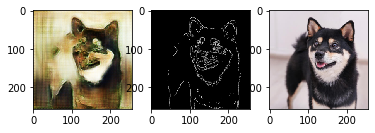

In [68]:
from __future__ import print_function
import argparse
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "checkpoint/dataset2/netG_model_epoch_50.pth"
net_g = torch.load(model_path).to(device)
image_dir = "dataset/test/b/"
image_filenames = [x for x in os.listdir(image_dir) if is_image_file(x)]
transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
transform = transforms.Compose(transform_list)

img_real = load_img('dataset/test/a/b (41).jpg')
img2 = load_img('dataset/test/b/b (41).jpg')
img = transform(img2)
input = img.unsqueeze(0).to(device)
out = net_g(input)
out_img = out.detach().squeeze(0).cpu()

cdog = np.transpose(vutils.make_grid(out_img, padding=2, normalize=True),(1,2,0)).numpy()
plt.subplot(1,3,1)
plt.imshow(cdog)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img_real)

#########test################
# for image_name in image_filenames:
#     img = load_img(image_dir + image_name)
#     img = transform(img)
#     input = img.unsqueeze(0).to(device)
#     out = net_g(input)
#     out_img = out.detach().squeeze(0).cpu()
#     save_img(out_img, "result/{}".format(image_name))

# SkipConnectionありのConvDeconv(U-Net)

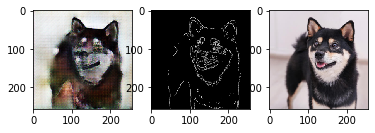

In [69]:
from __future__ import print_function
import argparse
import os
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import cv2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "checkpoint/dataset2/unetG_model_epoch_50.pth"
net_g = torch.load(model_path).to(device)
image_dir = "dataset/test/b/"
image_filenames = [x for x in os.listdir(image_dir) if is_image_file(x)]
transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
transform = transforms.Compose(transform_list)

img_real = load_img('dataset/test/a/b (41).jpg')
img2 = load_img('dataset/test/b/b (41).jpg')
img = transform(img2)
input = img.unsqueeze(0).to(device)
out = net_g(input)
out_img = out.detach().squeeze(0).cpu()

cdog = np.transpose(vutils.make_grid(out_img, padding=2, normalize=True),(1,2,0)).numpy()
plt.subplot(1,3,1)
plt.imshow(cdog)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img_real)

# 考察
pix2pixについてジェネレーターにUnet構造とダウンサンプリング-レスブロック-アップサンプリング構造を使用し、作成した柴犬データセット254枚で学習し、比較してみた。上の実行結果について、使用した柴犬のマスク画像の尻尾の部分は輪郭が途切れている。この画像で画像生成してみるとUnetのほうは途切れている輪郭も保ちつつ色を塗っているのに対し、通常のConvDeconvを用いた生成では尻尾のほうの輪郭の情報が消えてしまっていて背景と同化していることが分かる。このことから、Unet構造はダウンサンプリング中の特徴がアップサンプリングの特徴に埋め込まれていくため変換後の画像は一定レベルで同じ要素を持つといえる。